In [1]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign
from termcolor import colored
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torchani/aev.py:

In [2]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                        
                #print(f"Angle {atom1.GetSymbol()}-{atom2.GetSymbol()}-{neighbor.GetSymbol()}: {angle:.2f} rad")
                bond_angles.append(angle)

    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)


def get_diffs_internal_coords(mol1, mol2):
    bond_lengths_diff = torch.abs(get_bond_lengths(mol1) - get_bond_lengths(mol2)).mean()
    bond_angles_diff = torch.abs(get_bond_angles(mol1) - get_bond_angles(mol2)).mean()
    torsion_angles_diff = torch.abs(get_torsion_angles(mol1) - get_torsion_angles(mol2)).mean()
    #str = (f'Bond length diff: {bond_length_diff:.2f} Å, Bond angles diff: {bond_angles_diff:.2f} rad, Torsion angles diff: {torsion_angles_diff:.2f} rad')
    return bond_lengths_diff, bond_angles_diff, torsion_angles_diff
    #return str

def get_stds_internal_coords(mols):
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_std = torch.stack(all_bond_lengths).std(dim=0).mean()
    bond_angles_std = torch.stack(all_bond_angles).std(dim=0).mean()
    torsion_angles_std = torch.stack(all_torsion_angles).std(dim=0).mean()
    return bond_lengths_std, bond_angles_std, torsion_angles_std
    

In [3]:

def get_rmsds(mols, mols_optimized):
    rmsds = []
    for conf_idx in range(len(mols)):
        rmsds.append(fast_rmsd(mols[conf_idx], mols_optimized[conf_idx], conf1=0, conf2=0) )
    return rmsds

## Understanding relaxation

In [4]:
# load conformers_20steps.pkl
conformers_train = pickle.load(open('true_conformers_train_first_10smis.pkl', 'rb'))
conformers_gen = pickle.load(open('conformers_20steps_train_first_10smis.pkl', 'rb'))
conformers_optimized = pickle.load(open('conformers_20steps_train_first_10smis_optimized.pkl', 'rb'))
smis = list(conformers_gen.keys())

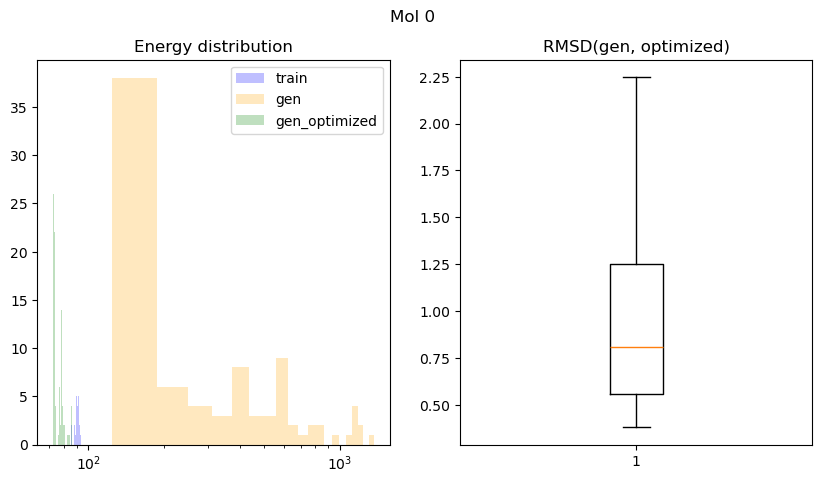

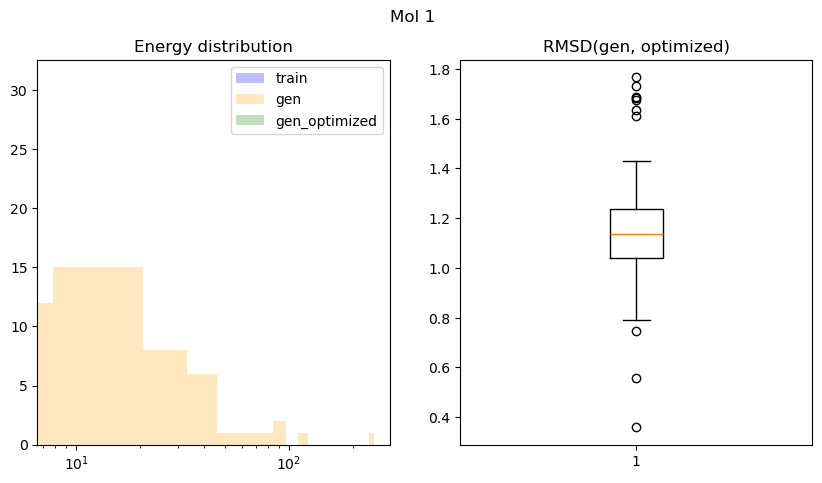

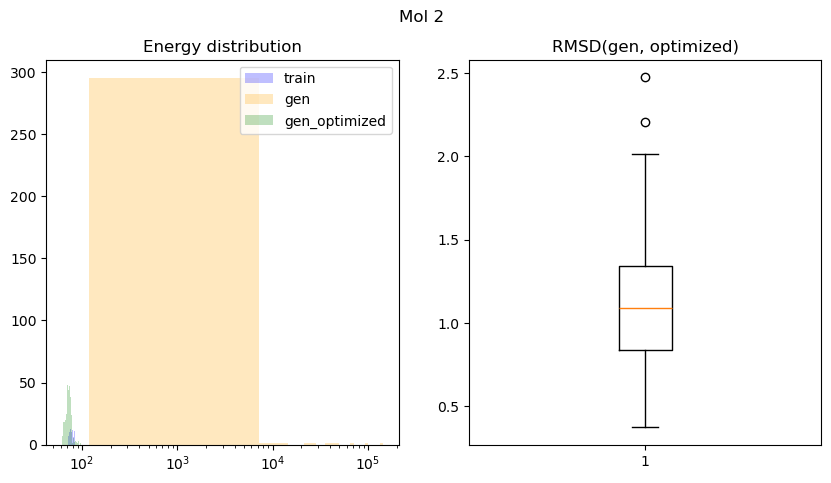

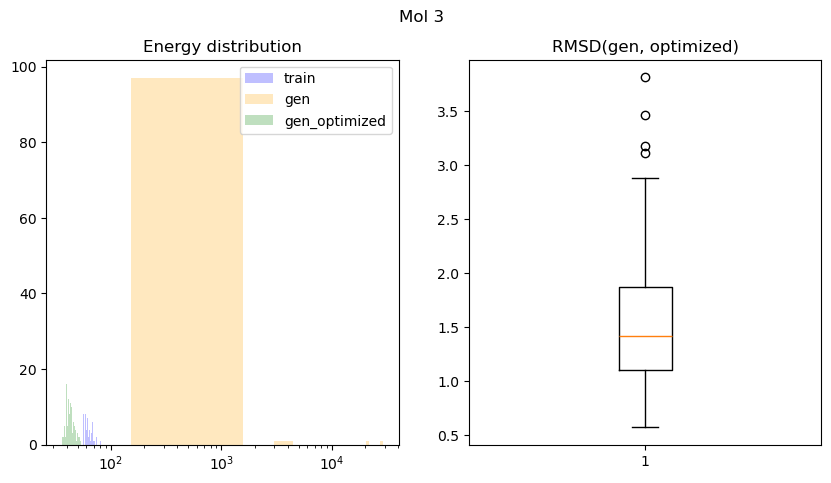

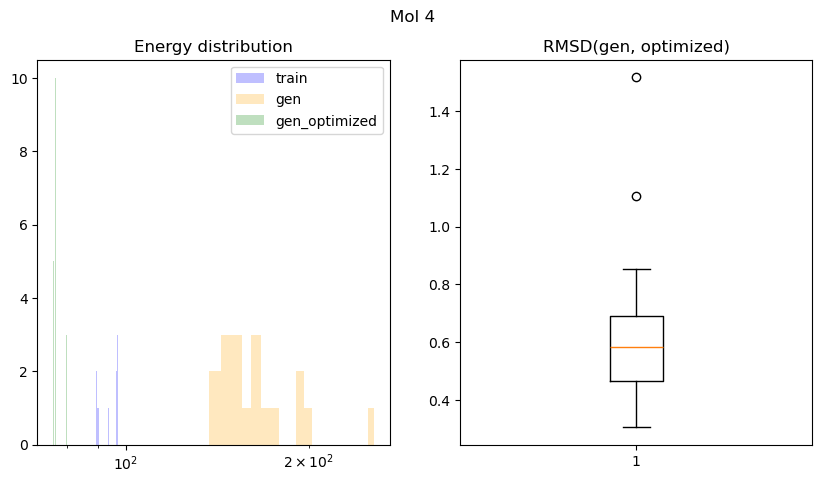

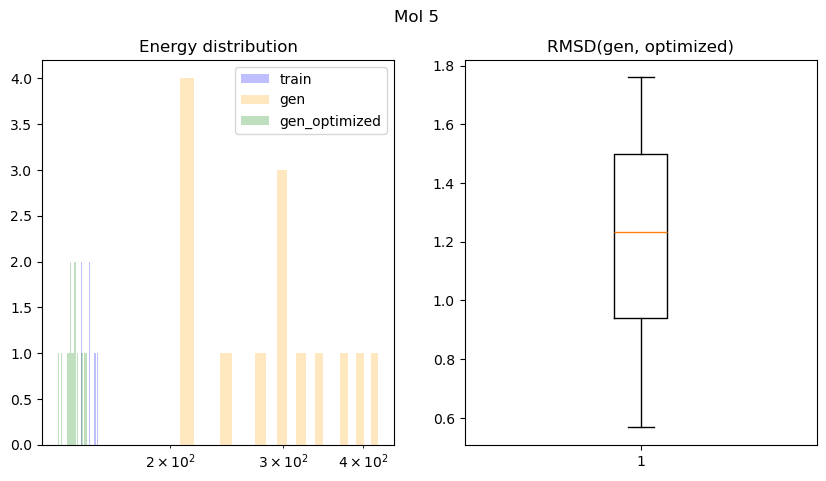

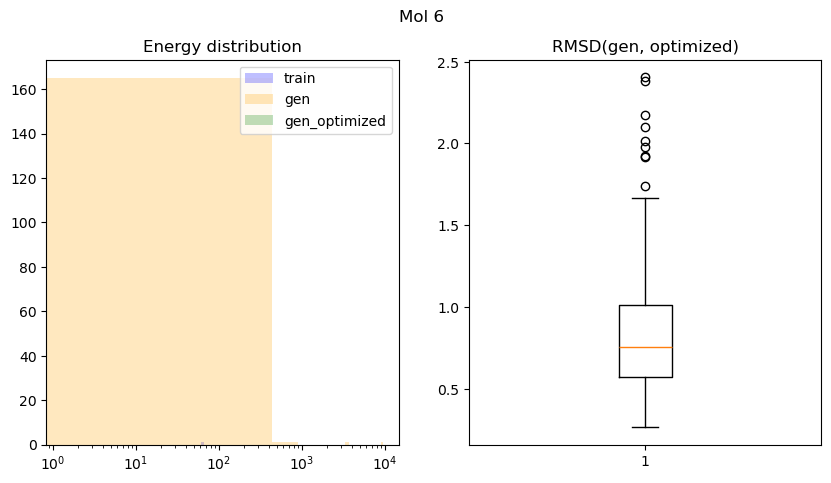

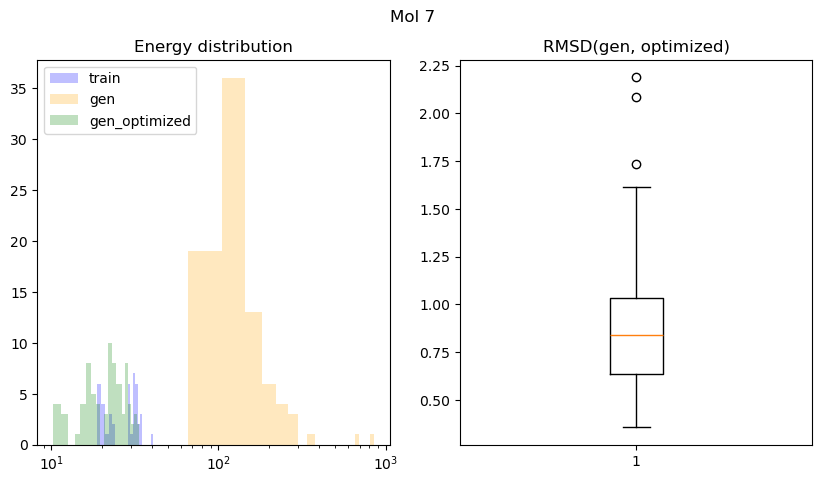

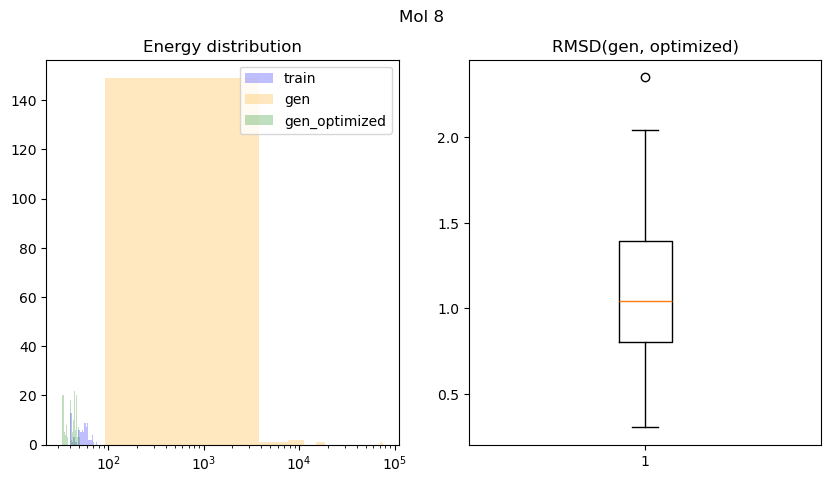

In [5]:
for i, smile in enumerate(smis): 
    #Plt figure with 2 subfigures
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    #Plot the hists in the first subfigure
    ax[0].hist([mmff_energy(mol) for mol in mols_train], bins=20, color = 'blue', label='train', alpha=0.25  )
    ax[0].hist([mmff_energy(mol) for mol in mols_gen], bins=20, color = 'orange',label='gen', alpha=0.25)
    ax[0].hist([mmff_energy(mol) for mol in mols_optimized], bins=20, color = 'green',label='gen_optimized', alpha=0.25)
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[0].set_title(f'Energy distribution')
    # Plot the RMSD in the second subfigure
    rmsds = get_rmsds(mols_gen, mols_optimized)
    ax[1].boxplot(rmsds)
    ax[1].set_title(f'RMSD(gen, optimized)')
    # add title to the whole figure
    fig.suptitle(f'Mol {i}')
    #Add title for the whole figure
    i+=1
    #if i ==1:
        #break


### Visualise structures before and after optimization

In [6]:
smile, conf_idx = smis[5], 3
mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
#Plot the hists in the first subfigure

mol1, mol2 =mols_gen[conf_idx], mols_optimized[conf_idx]
rdMolAlign.AlignMol(mol1, mol2)

# Convert to mol blocks
mol1_block = Chem.MolToMolBlock(mol1)
mol2_block = Chem.MolToMolBlock(mol2)

view = py3Dmol.view(width=400, height=400)
view.addModel(mol1_block, "mol")
view.addModel(mol2_block, "mol")
view.setStyle({'model': 0}, {'stick': {'color': 'red'}})
view.setStyle({'model': 1}, {'stick': {'color': 'blue'}})
view.addLabel('Before (red) vs after (bue) optimization}',{'position': {'x': 0, 'y': 8, 'z': 0}, 
               'backgroundColor': 'white', 
               'fontColor': 'black', 
               'fontSize': 16, 
               'alignment': 'topCenter'})
'''
for i in range(mol1.GetNumAtoms()):
    atom = mol1.GetAtomWithIdx(i)
    pos = mol1.GetConformer().GetAtomPosition(i)
    view.addLabel(str(i), {'position': {'x': pos.x, 'y': pos.y, 'z': pos.z},
                           'backgroundColor': 'lightgray',
                           'fontColor': 'black',
                           'fontSize': 14})
'''
view.zoomTo()

# Show the viewer
view.show()
bond_lengths_diff, bond_angles_diff, torsion_angles_diff = get_diffs_internal_coords(mol1, mol2)
print(f'mol={smile}, confID={conf_idx}, ', f'Bond length diff: {bond_lengths_diff:.2f} Å, Bond angles diff: {bond_angles_diff:.2f} rad, Torsion angles diff: {torsion_angles_diff:.2f} rad' , 'RMSD', fast_rmsd(mol1, mol2, conf1=0, conf2=0) )


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

mol=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1, confID=3,  Bond length diff: 0.02 Å, Bond angles diff: 0.06 rad, Torsion angles diff: 1.13 rad RMSD 1.330264577553626


Let's look at the internal coordinate differences before vs after relaxation, for bond lengths, bond angles and torsion angles:

In [7]:

for smile in smis:
    print(f'MOL={smile}')
    bond_lengths_diffs = 0
    bond_angles_diffs = 0
    torsion_angles_diffs = 0
    mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    for conf_idx in range(len(mols_train)):
        mol1, mol2 =mols_gen[conf_idx], mols_optimized[conf_idx]
        bond_lengths_diff, bond_angles_diff, torsion_angles_diff = get_diffs_internal_coords(mol1, mol2)
        bond_lengths_diffs +=bond_lengths_diff
        bond_angles_diffs +=bond_angles_diff
        torsion_angles_diffs += torsion_angles_diff
    print(f'Mean Bond length diff: {bond_lengths_diffs/len(mols_train):.2f} Å, Mean Bond angles diff: {bond_angles_diffs/len(mols_train):.2f} rad, Mean Torsion angles diff: {torsion_angles_diffs/len(mols_train):.2f} rad' )


MOL=COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.32 rad
MOL=S=C(NCc1ccc2c(c1)OCO2)NC1CC1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.04 rad
MOL=CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.06 rad, Mean Torsion angles diff: 1.06 rad
MOL=Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1
Mean Bond length diff: 0.04 Å, Mean Bond angles diff: 0.09 rad, Mean Torsion angles diff: 1.40 rad
MOL=CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.27 rad
MOL=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.11 rad
MOL=[NH3+]CCCP(=O)(O)CCc1ccccc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.05 rad, Mean Torsion angles diff: 1.19 rad
MOL=Cc1c

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising

**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

In [22]:
for smile in smis:
    print(f'MOL={smile}')
    mols_train = conformers_train[smile]
    bond_lengths_std, bond_angles_std, torsion_angles_std = get_stds_internal_coords(mols_train)
    print(f'std Bond length: {bond_lengths_std:.2f} Å, Std Bond angles: {bond_angles_std:.2f} rad, Std Torsion angles diff: {torsion_angles_std:.2f} rad' )


MOL=COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1
std Bond length: 0.00 Å, Std Bond angles: 0.01 rad, Std Torsion angles diff: 1.62 rad
MOL=S=C(NCc1ccc2c(c1)OCO2)NC1CC1
std Bond length: 0.00 Å, Std Bond angles: 0.01 rad, Std Torsion angles diff: 1.04 rad
MOL=CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1
std Bond length: 0.00 Å, Std Bond angles: 0.01 rad, Std Torsion angles diff: 1.31 rad
MOL=Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1
std Bond length: 0.00 Å, Std Bond angles: 0.01 rad, Std Torsion angles diff: 1.64 rad
MOL=CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1
std Bond length: 0.00 Å, Std Bond angles: 0.02 rad, Std Torsion angles diff: 1.43 rad
MOL=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1
std Bond length: 0.00 Å, Std Bond angles: 0.02 rad, Std Torsion angles diff: 1.26 rad
MOL=[NH3+]CCCP(=O)(O)CCc1ccccc1


RuntimeError: stack expects each tensor to be equal size, but got [34] at entry 0 and [33] at entry 77

## Dataset Exploration

In [2]:
from utils.dataset import *
data_dir='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs/'
split_path='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/split_boltz_10k.npy'
mode = 'train'
dataset='drugs'
types = 
transform=None
num_workers = 1
limit_molecules = 0
cache = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run'
pickle_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/standardized_pickles'
boltzmann_resampler = None

dataset = ConformerDataset(data_dir, split_path, mode, dataset,
                                   types, transform,
                                   num_workers,
                                   limit_molecules,
                                   cache,
                                   pickle_dir,
                                   boltzmann_resampler)
print(f'Number of datapoints {len(dataset.datapoints)}')

loader = DataLoader(dataset=dataset,
                            batch_size=32,
                            shuffle=False if mode == 'test' else True)

Reusing preprocessing from cache /home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run.train
Number of datapoints 9295


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
from diffusion.likelihood import mmff_energy

In [73]:
canonical_smis = [x.canonical_smi for x in dataset.datapoints]
dict_mols = {}
lengths = [15, 20, 30, 40, 50, 60, 67]
for length in lengths:
    condition = [(len(x.z) <= length+2) and (len(x.z) >= length+2) for x in dataset.datapoints]
    dict_mols[length] = [dataset.datapoints[i] for i in range(len(canonical_smis)) if condition[i]]
print([len(dict_mols[length]) for length in lengths])

[9, 42, 357, 411, 130, 18, 6]


In [74]:
def set_positions(mol, pos):
    coords = pos.double().numpy()
    for i in range(len(pos)):
        mol.GetConformer().SetAtomPosition(i, Geometry.Point3D(coords[i, 0], coords[i, 1], coords[i, 2]))

energies = {}
for length in lengths:
    energies[length] = []
    print(f'Length={length}')
    batch = dict_mols[length]
    for i in range(len(batch)):
        mol = batch[i].mol
        for pos in batch[i].pos:
            set_positions(mol, pos)
            energies[length].append(mmff_energy(mol))


Length=15
Length=20
Length=30
Length=40
Length=50
Length=60
Length=67


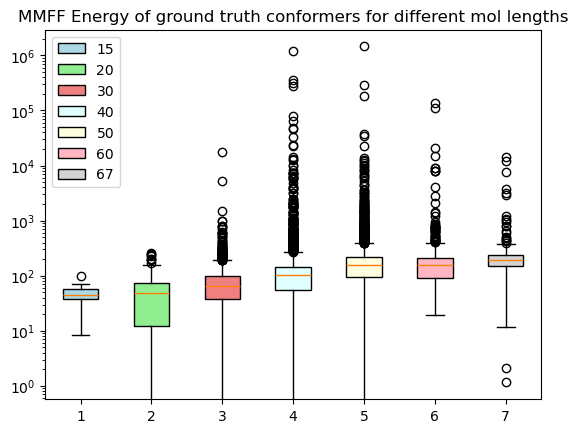

In [75]:
fig, ax = plt.subplots()
data_values = [values for values in energies.values()]
data_keys = list(dict_mols.keys())
box = ax.boxplot(data_values,patch_artist=True, label = data_keys)
# Define colors
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightcyan', 'lightyellow', 'lightpink', 'lightgray']

# Set colors for each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax.legend()
ax.set_yscale('log')
ax.set_title(f'MMFF Energy of ground truth conformers for different mol lengths')
# add x title
ax.set_xticklabels(data_keys)
plt.show()

Todo : enlever les energies des atomes

In [76]:
loader = DataLoader(dataset=dataset,
                            batch_size=32,
                            shuffle=False if mode == 'test' else True)

In [16]:
path = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs'
#Iterate over the files in path and store their names
smis = []
for file in os.listdir(path):
    smis.append(file.split('.')[0])
print('smis', smis[:10])
# Make a pickle file with the ground truth confs for the first 10 smis
training_confs = {}
for i,smi in enumerate(smis[:10]):
    if smi not in training_confs.keys():
        training_confs[smi] = []
    conf_smi = pickle.load(open(f'{path}/{smi}.pickle', 'rb'))['conformers']
    for j in range(len(conf_smi)):
        training_confs[smi].append(conf_smi[j]['rd_mol'])
# save the pickle file training_confs
pickle.dump(training_confs, open('true_conformers_train_first_10smis.pkl', 'wb'))

smis ['CCOC(=O)c1ccc(N2NC(=O)_C(=C_c3ccc([N+](=O)[O-])o3)C2=O)cc1', 'COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1', 'S=C(NCc1ccc2c(c1)OCO2)NC1CC1', 'CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1', 'Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1', 'CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1', 'CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1', '[NH3+]CCCP(=O)(O)CCc1ccccc1', 'Cc1ccccc1NC(=O)c1ccc(NC(=O)C2CC(=O)OC23CCCCC3)cc1', 'O=C(Nc1ccccc1Oc1ccsc1C(=O)O)c1ccccc1']


## Visualise stuff for diffusion model

In [2]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
def read_pickle(name):
    return pickle.load(open(name, 'rb'))

energies_train_on_policy = read_pickle('energies_train_on_policy.pkl')
energies_train_rand = read_pickle('energies_train_rand.pkl')
logpT_train_on_policy = read_pickle('logpT_train_on_policy.pkl')
logpT_train_rand = read_pickle('logpT_train_rand.pkl')

In [3]:
len(energies_train_on_policy), len(energies_train_rand), len(logpT_train_on_policy), len(logpT_train_rand)

(96, 96, 96, 96)

In [4]:
energies_train_on_policy.keys()

dict_keys(['Brc1c(CSc2nncn2-c2ccccc2)nc2sccn12', 'Brc1cc2c(cc1Cn1c(-c3cncs3)nc3ccccc31)OCO2', 'Brc1cc2c(cc1C=NNc1nc(N3CCCC3)nc(N3CCOCC3)n1)OCO2', 'Brc1cc2c(cc1C=NNc1nc(N3CCCCC3)nc(N3CCCCC3)n1)OCO2', 'Brc1ccc(-c2nc(NN=Cc3cccnc3)c3ccccc3n2)cc1', 'Brc1ccc(-c2nnc3sc(CN4CCC5(CC4)OCCO5)cn23)cc1', 'Brc1ccc(-c2nnc3sc(CNCc4ccc5c(c4)OCO5)cn23)cc1', 'Brc1ccc(COc2ncnc3ccccc23)cc1', 'Brc1ccc(CSc2ccc3nnc(-c4ccccn4)n3n2)cc1', 'Brc1ccc(CSc2ncnc3nc[nH]c23)cc1', 'Brc1ccc(CSc2nnc(-c3ccco3)o2)cc1', 'Brc1ccc2ncnc(NCc3ccccc3)c2c1', 'Brc1cccc(-c2nnc3sc(CN4CCC5(CC4)OCCO5)cn23)c1', 'Brc1ccccc1-c1nnc(CSc2nncn2-c2ccccc2)o1', 'Brc1ccccc1-c1nnc2sc(Cc3ccccc3)nn12', 'Brc1ccccc1C=NNc1nc2ccccc2o1', 'C#CC1(O)CCC2C3CCc4cc(OC)ccc4C3CCC21C', 'C#CC1(OC(C)=O)CCC2C3CCC4=CC(=O)CCC4C3CCC21C', 'C#CCCCc1nc2ccccc2c(=O)n1N', 'C#CCN(C(=O)Nc1ccccc1)c1ccccc1', 'C#CCN1C(=O)C(O)(CC(=O)c2ccc3c(c2)OCCO3)c2ccccc21', 'C#CCNC(=O)c1cc2sccc2n1C', 'C#CCOc1ccc(Cl)cc1C=NO', 'C#CCOc1ccc(C=NO)cc1Cl', 'C#CCOc1ccccc1C=C1C(=O)ON=C1C', 'C#CCSc1ncc(-c2

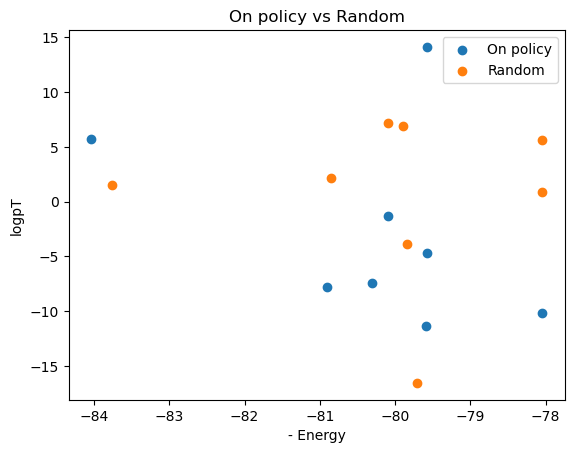

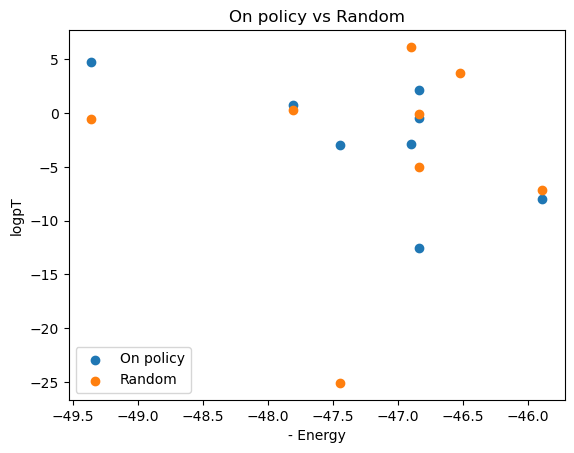

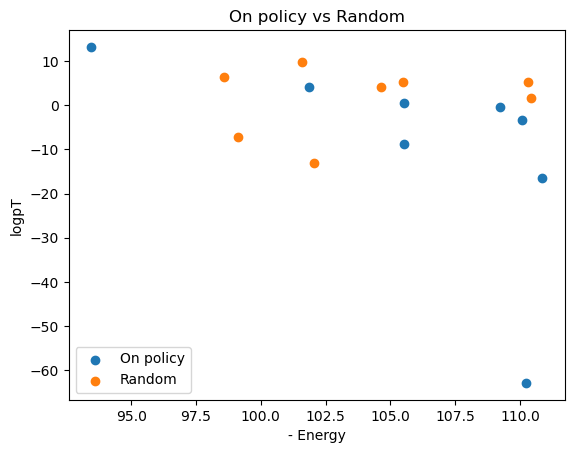

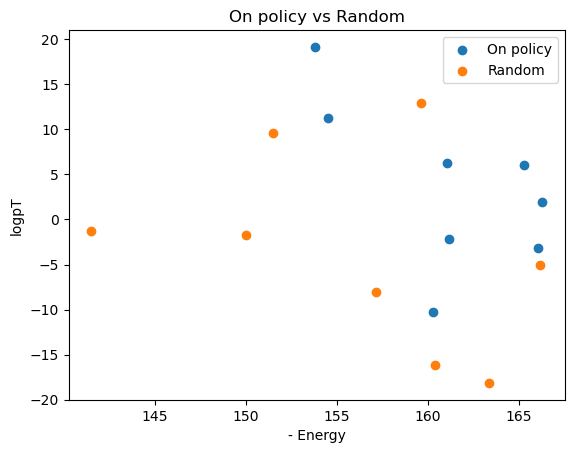

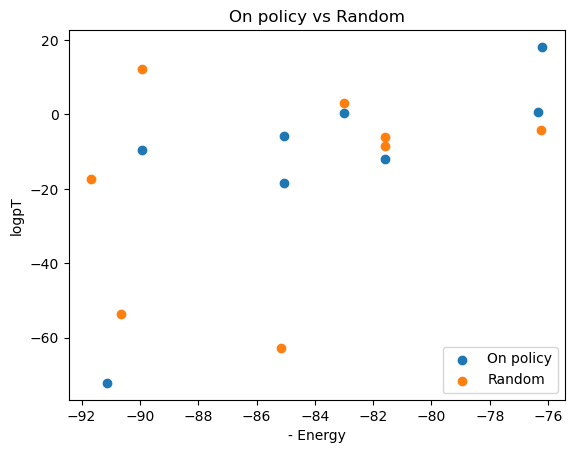

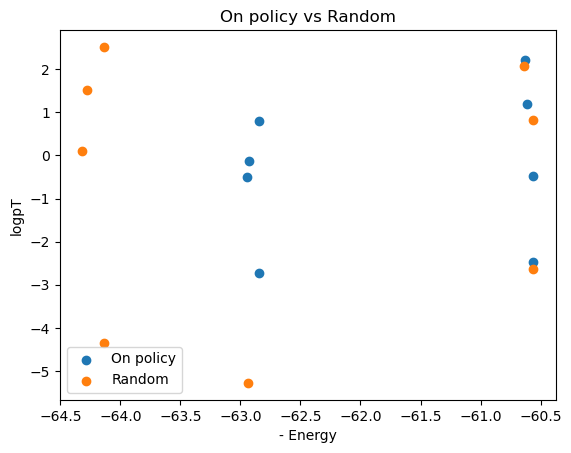

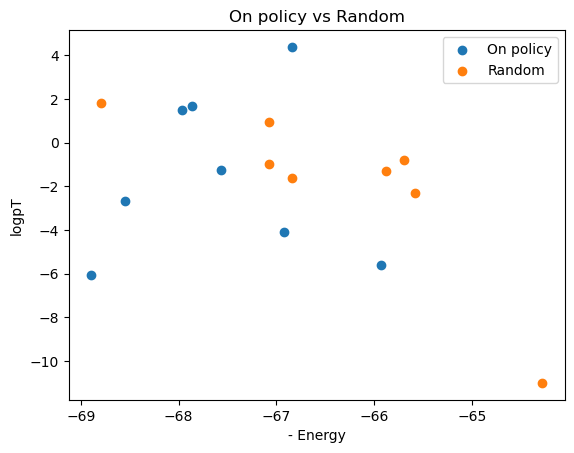

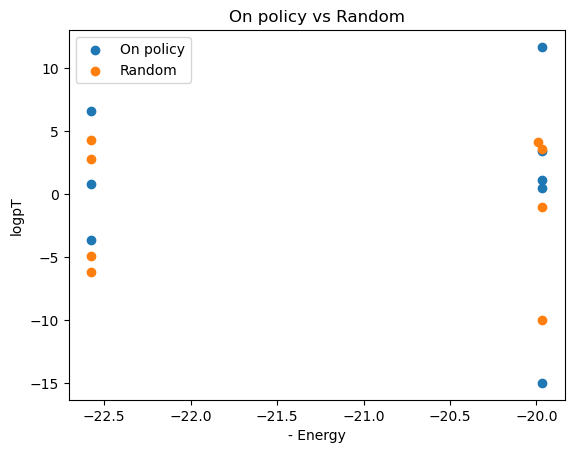

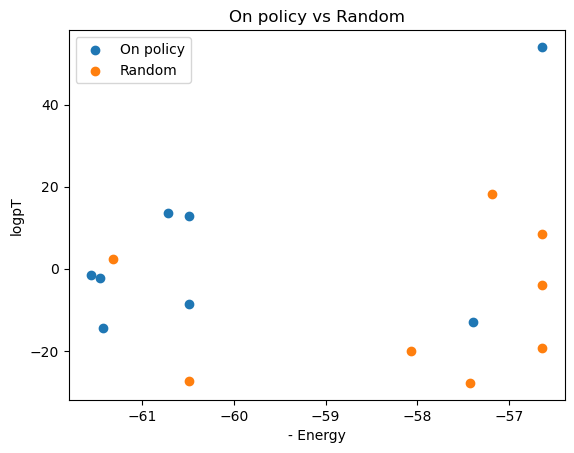

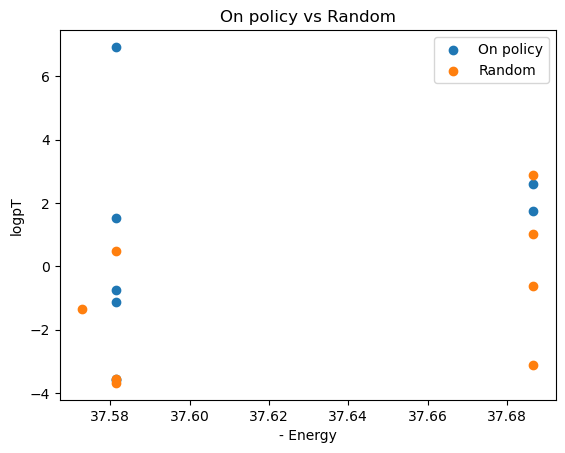

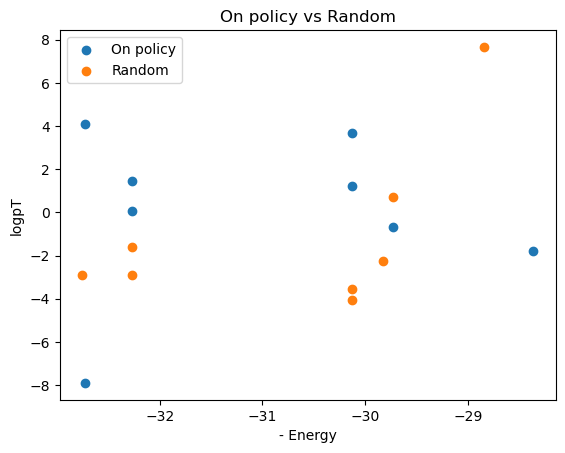

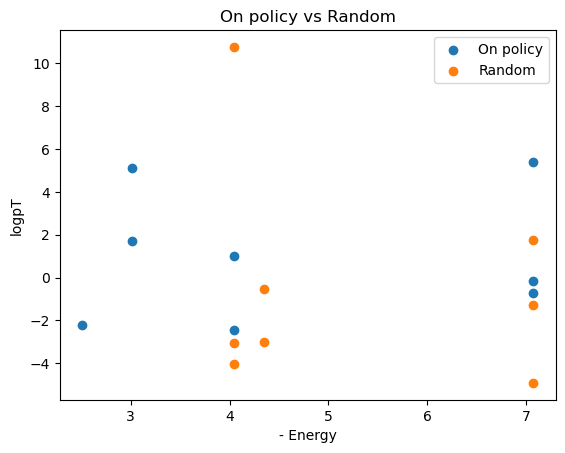

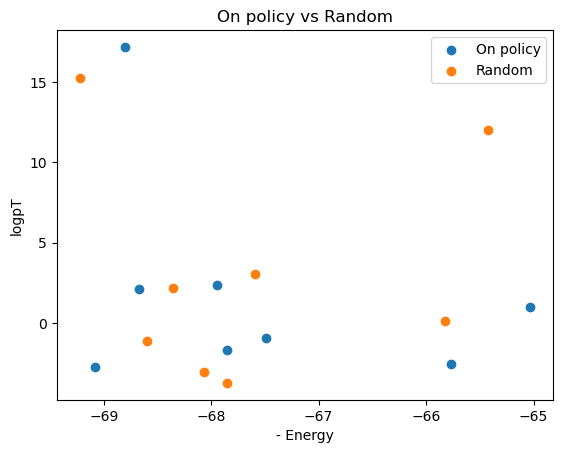

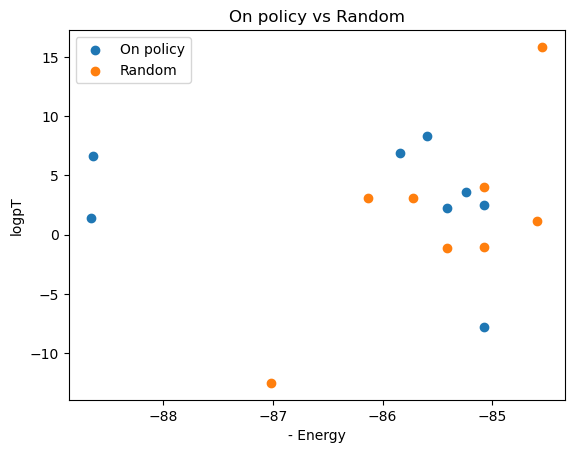

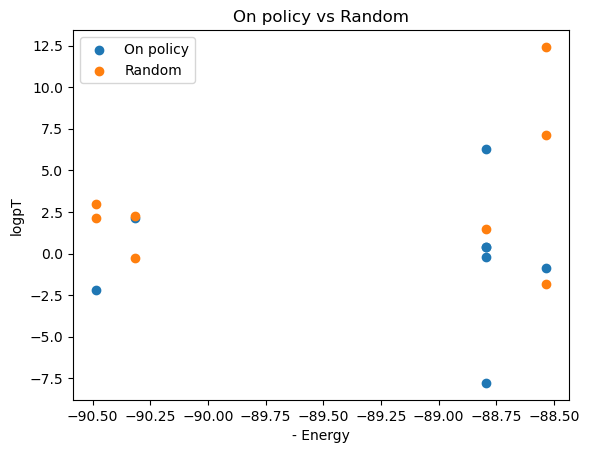

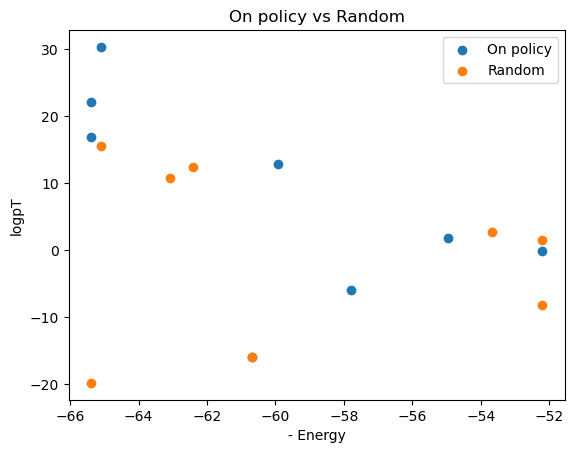

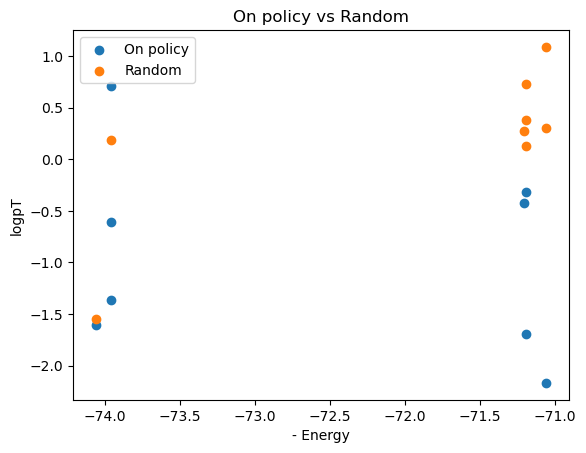

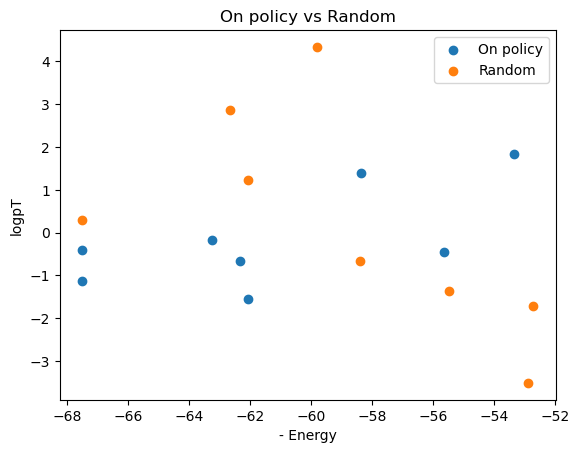

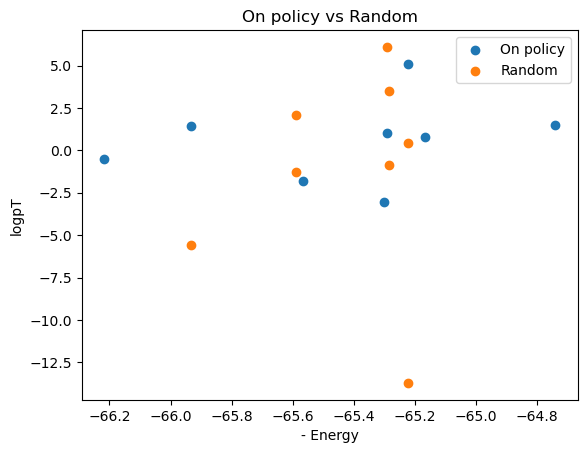

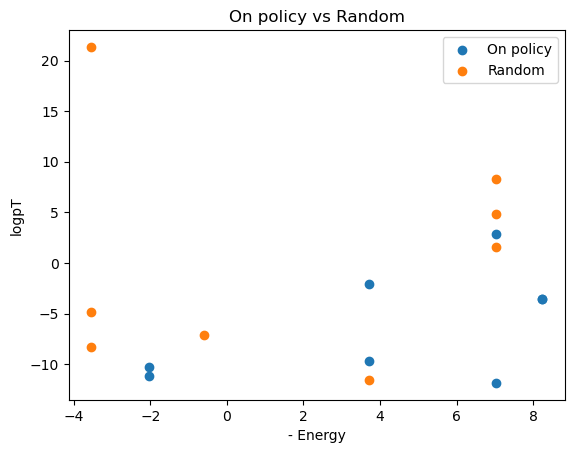

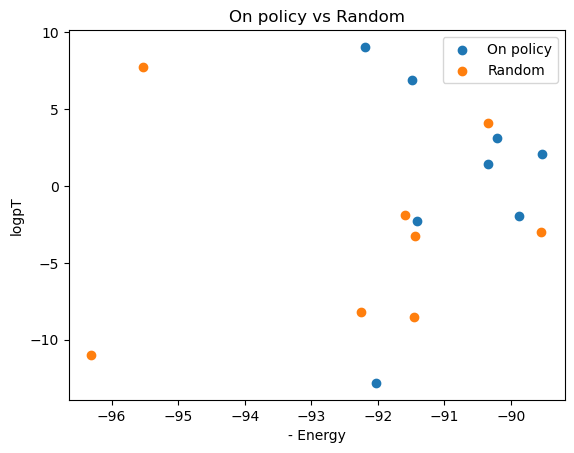

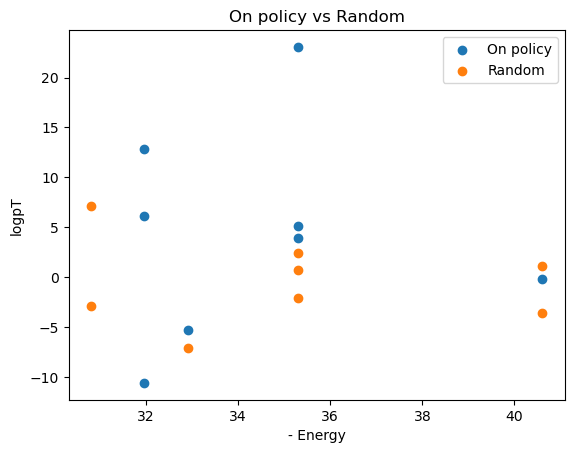

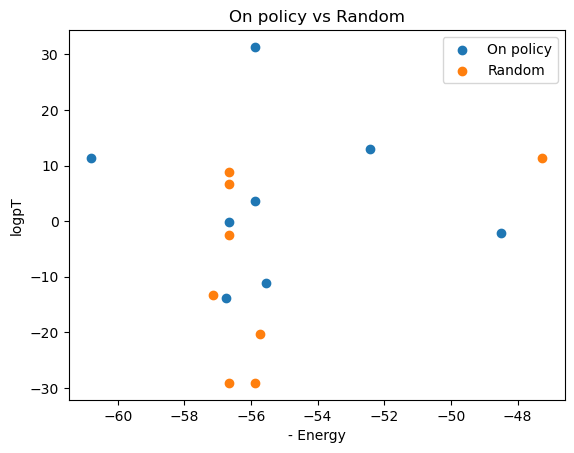

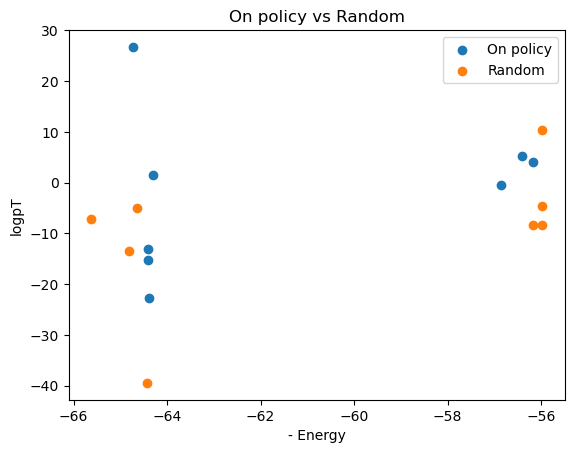

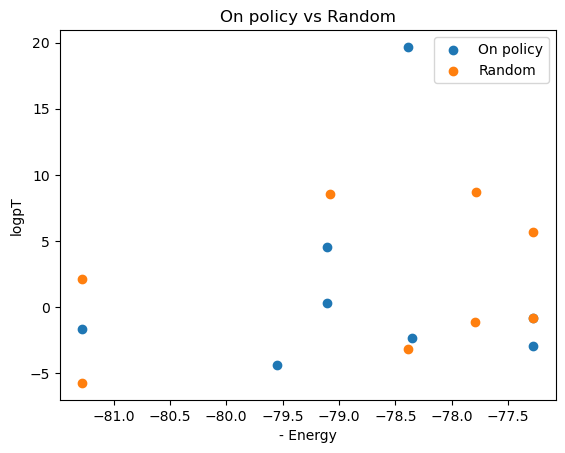

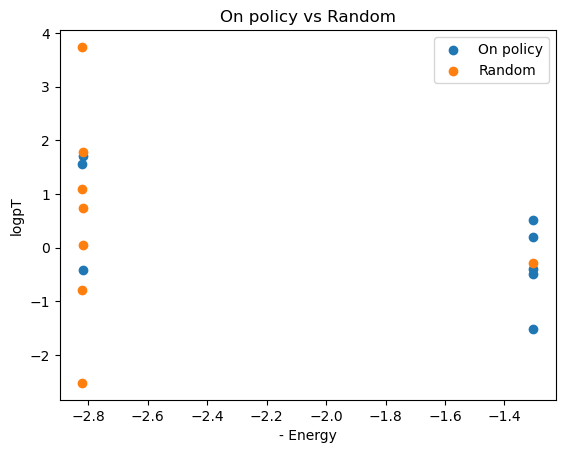

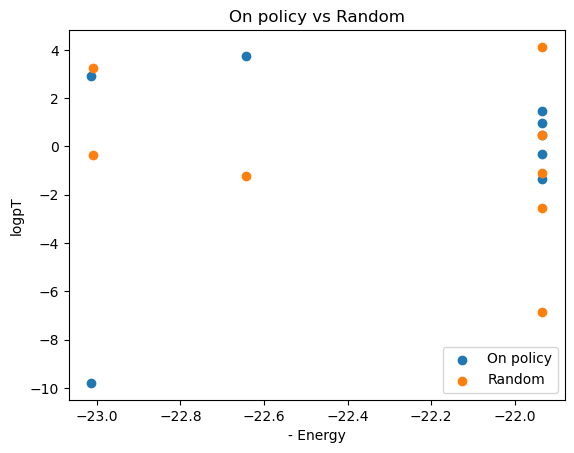

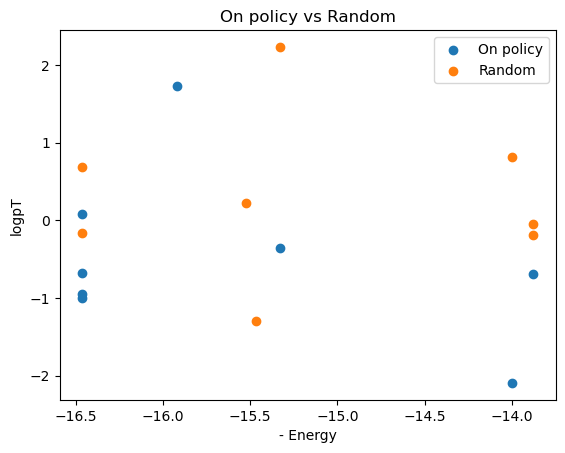

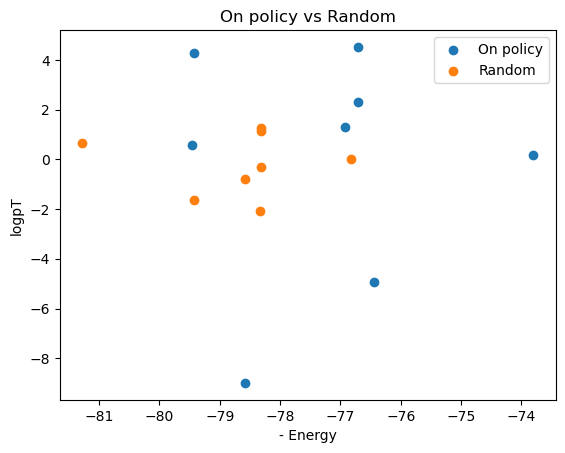

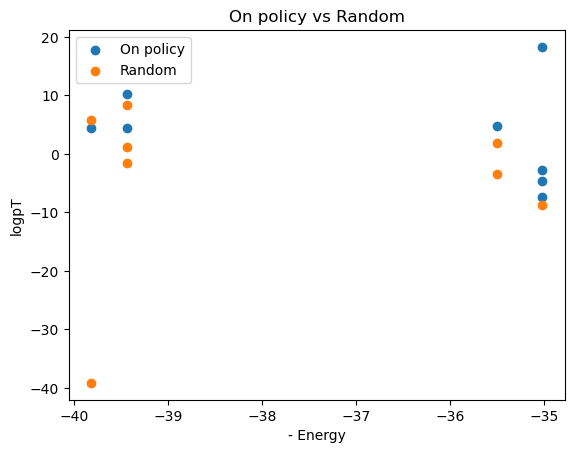

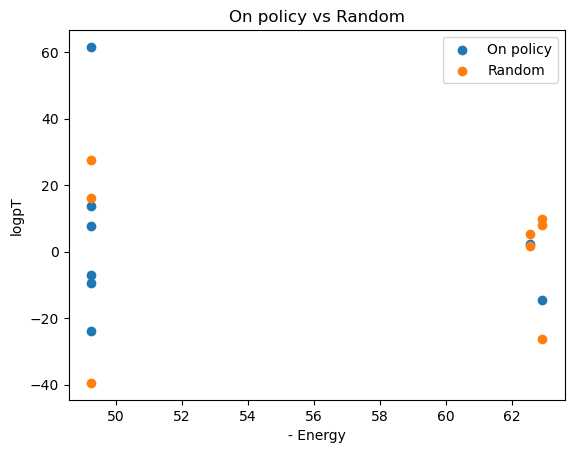

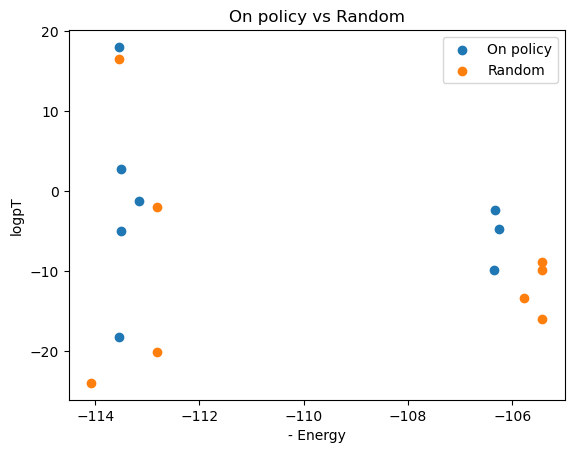

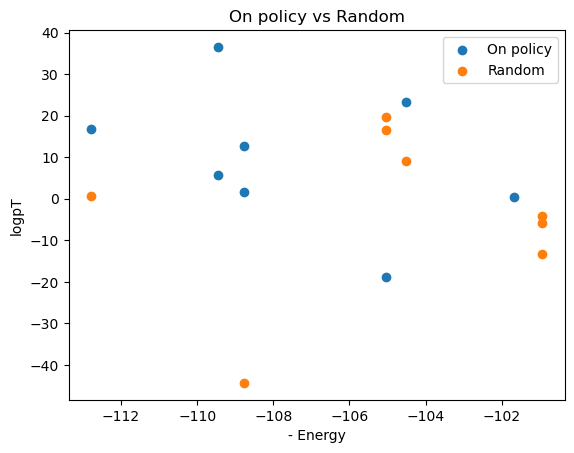

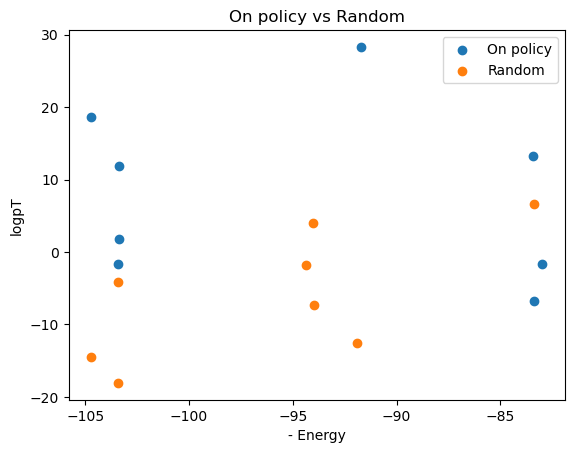

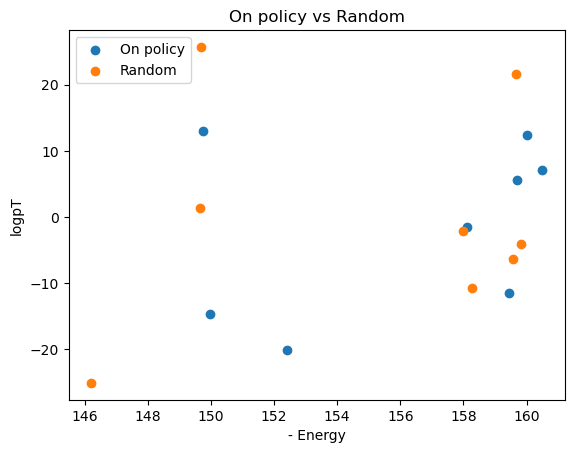

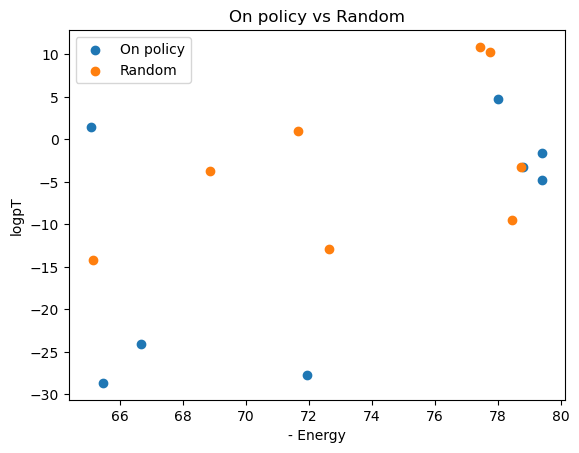

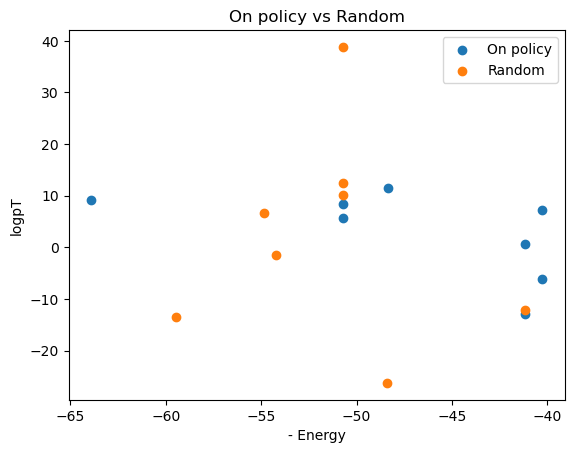

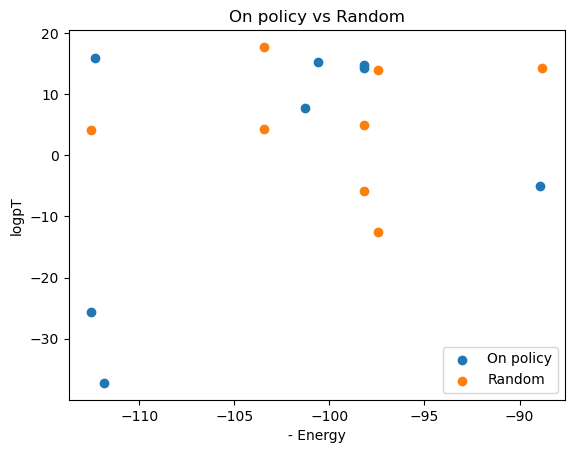

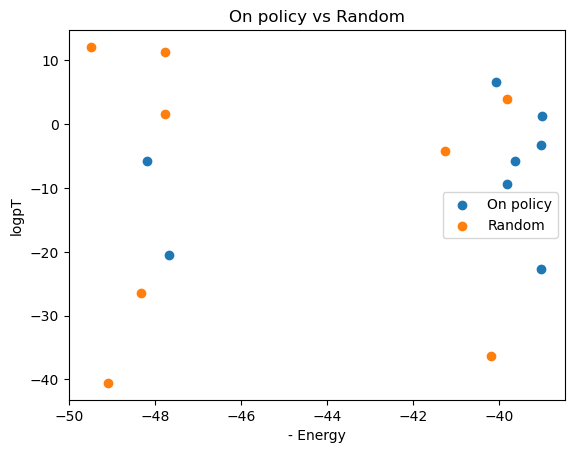

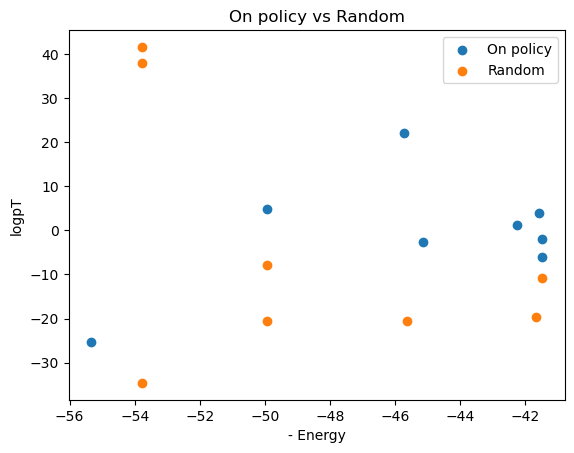

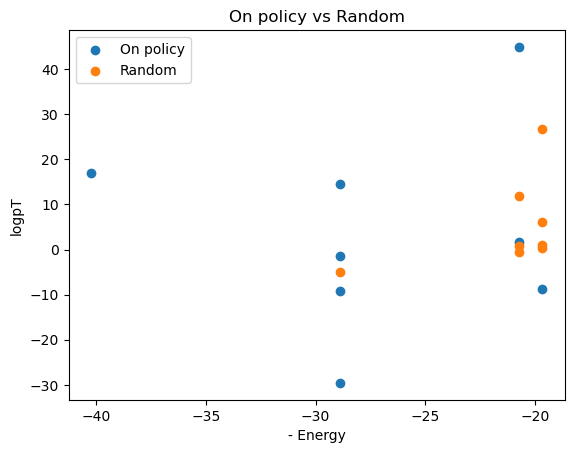

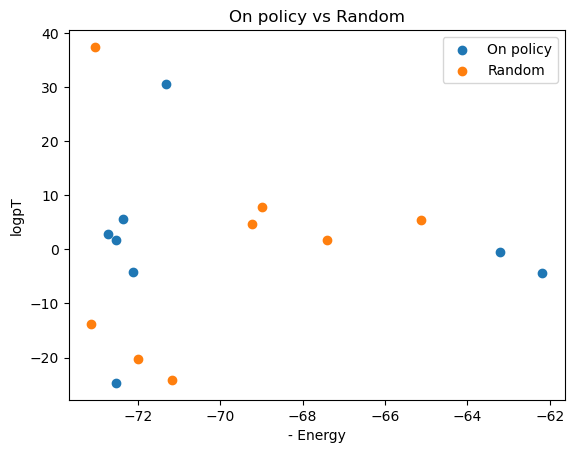

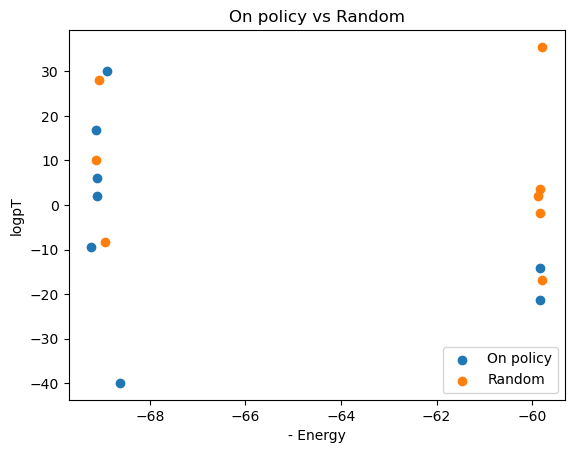

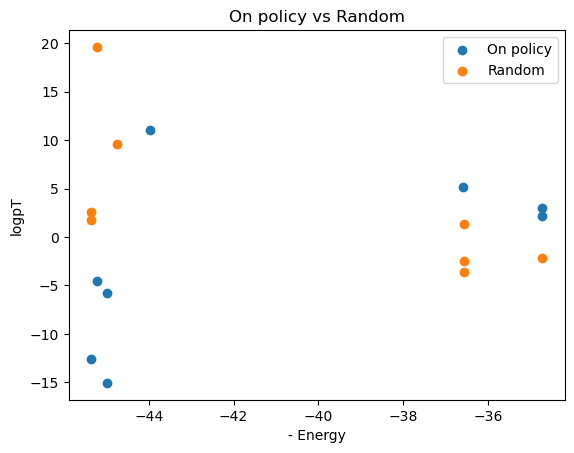

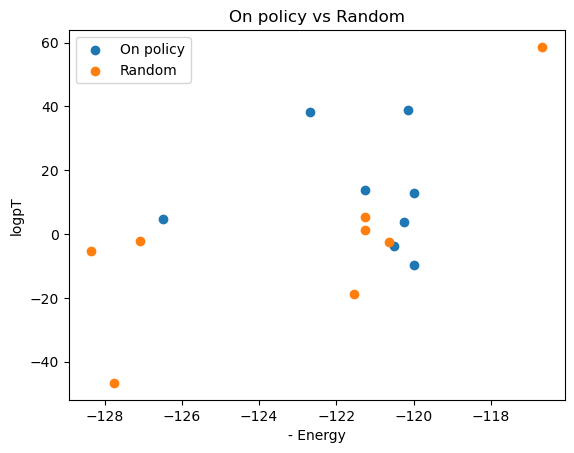

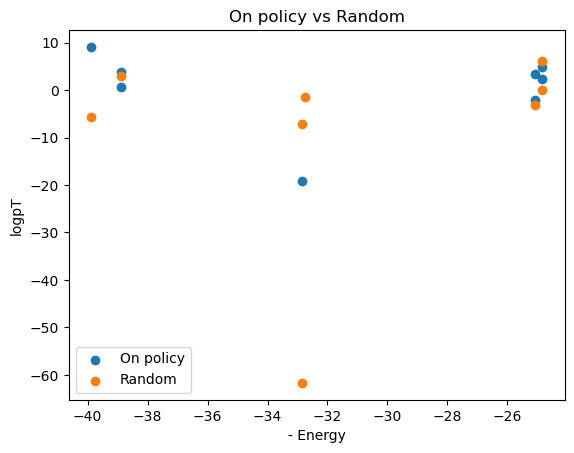

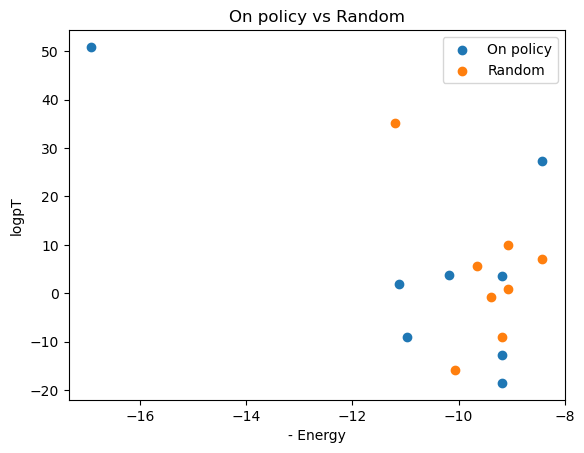

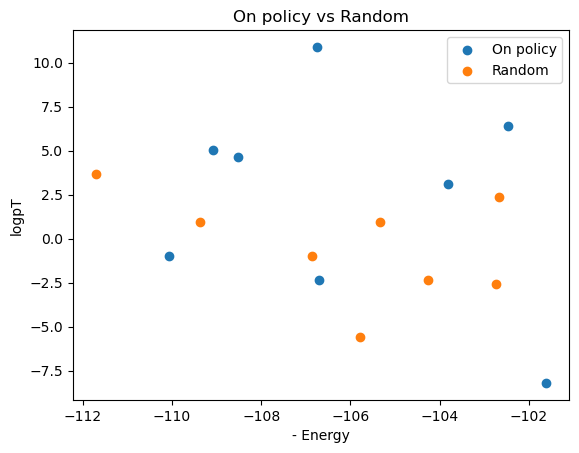

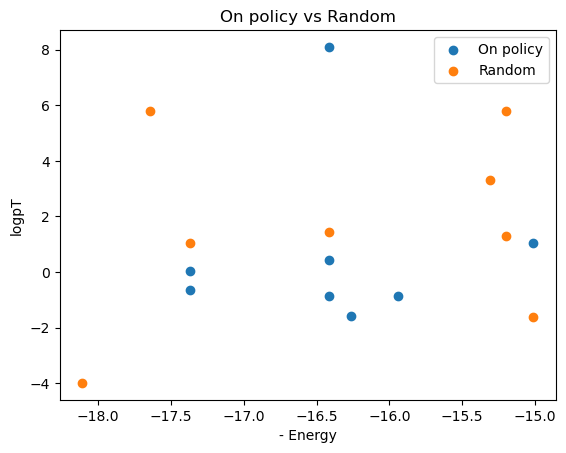

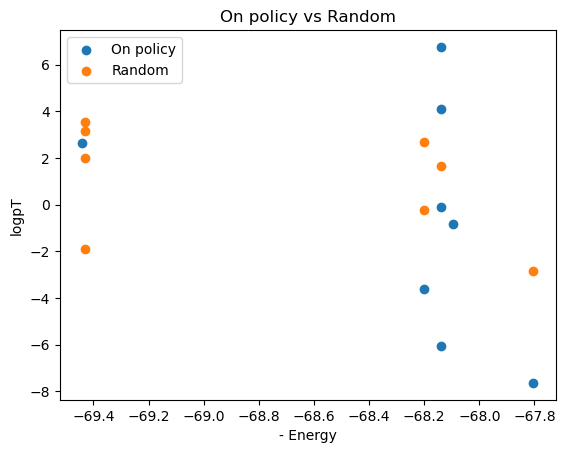

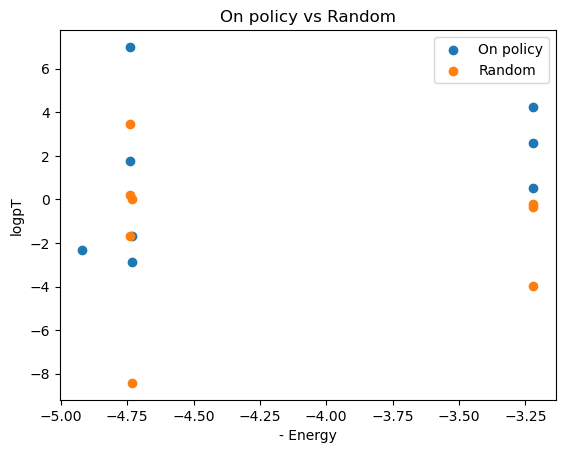

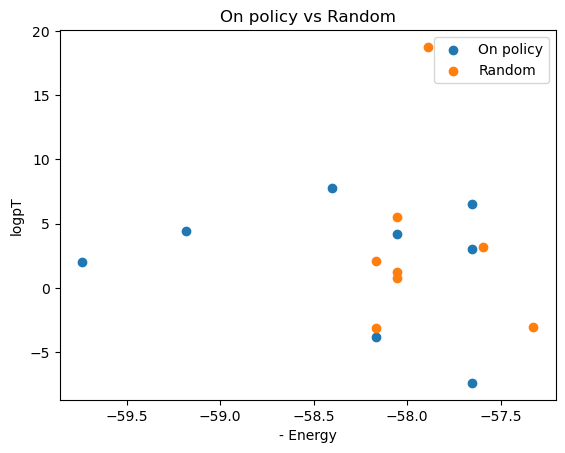

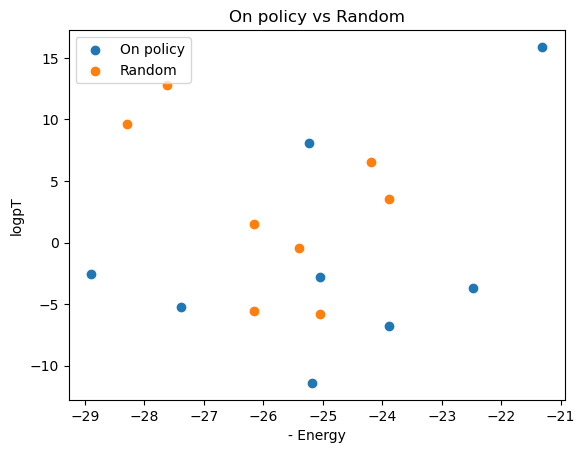

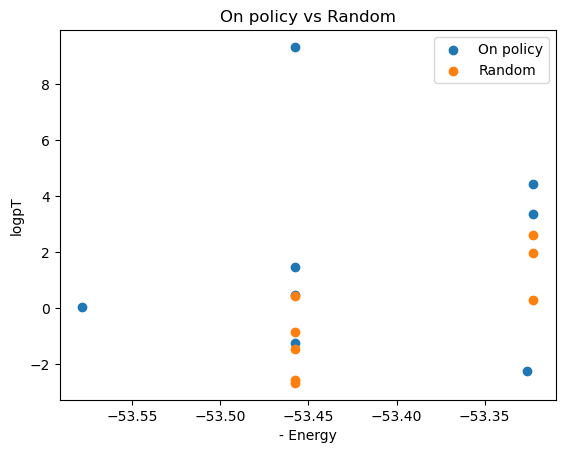

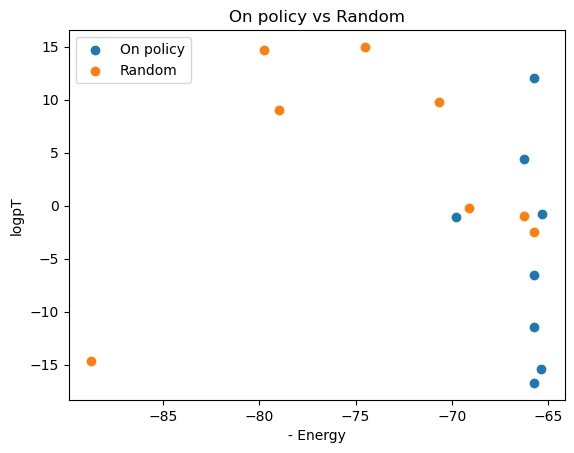

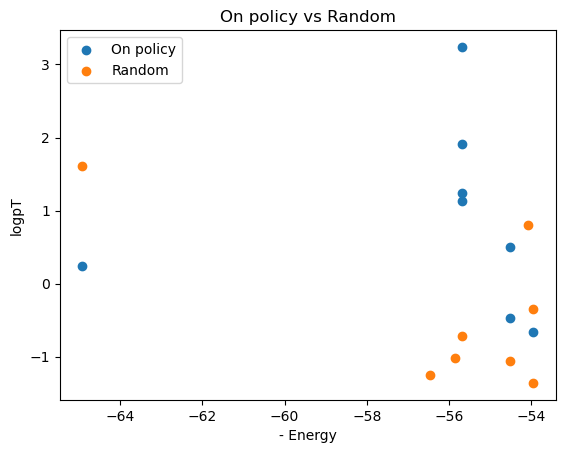

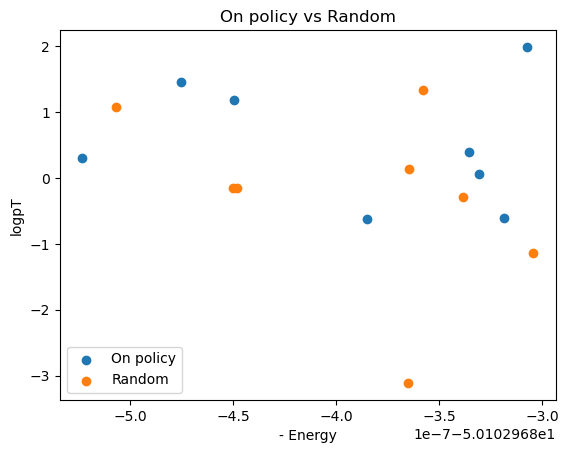

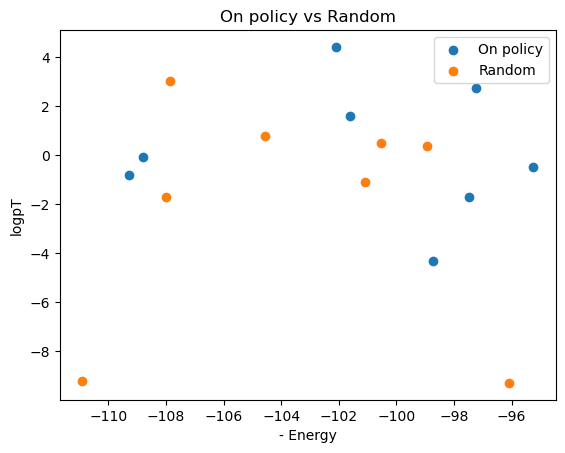

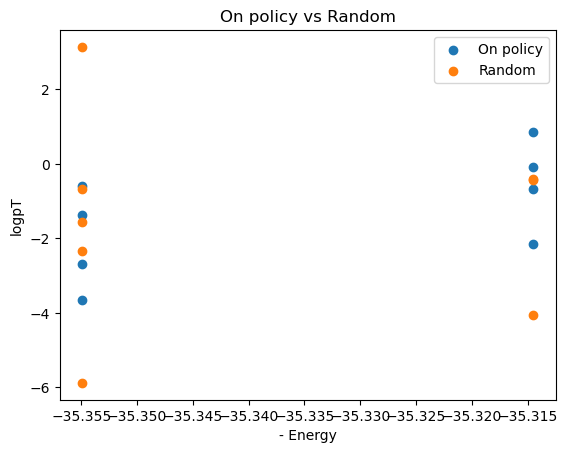

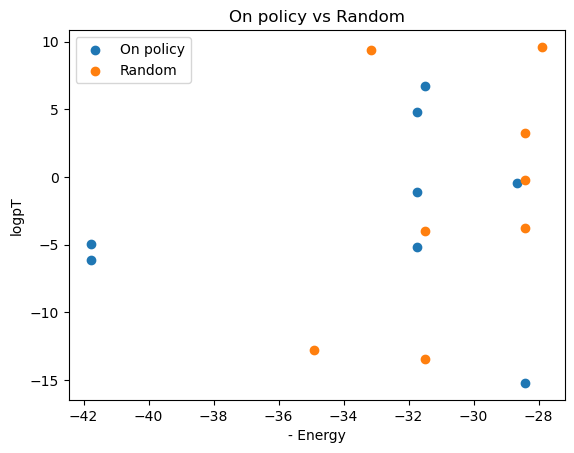

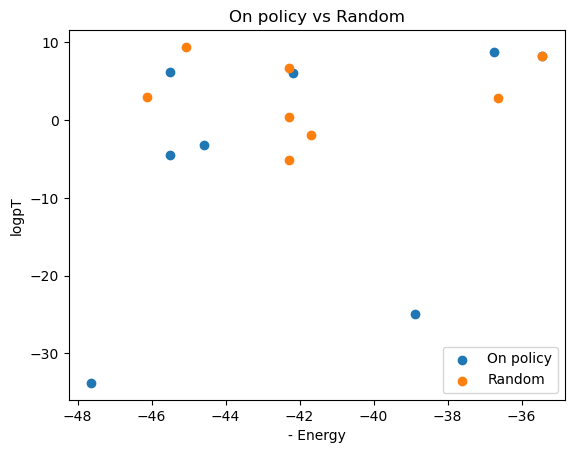

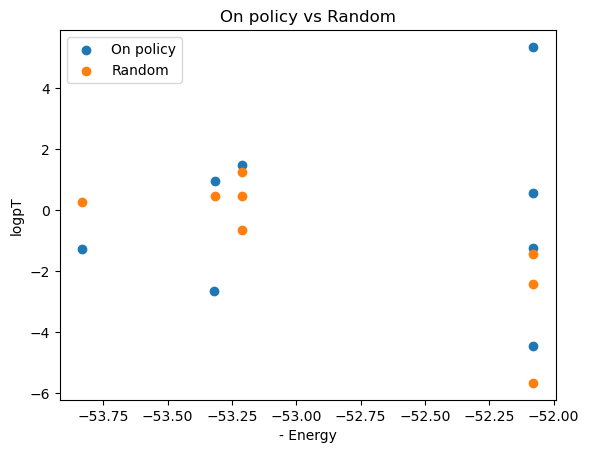

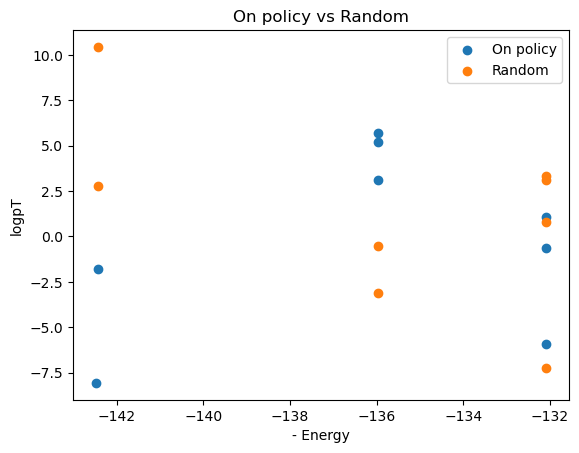

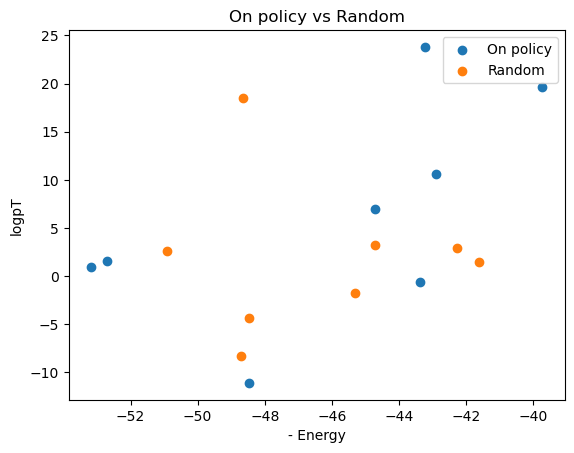

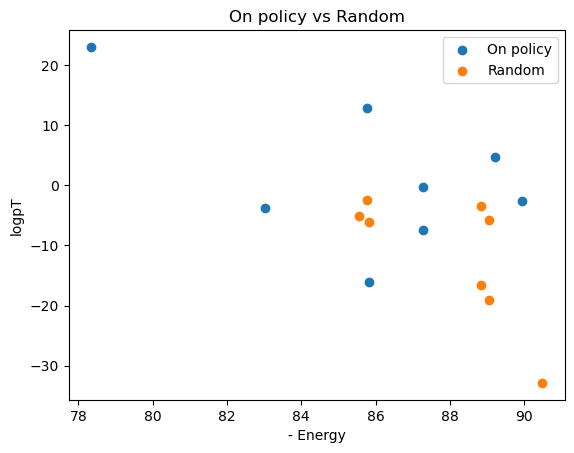

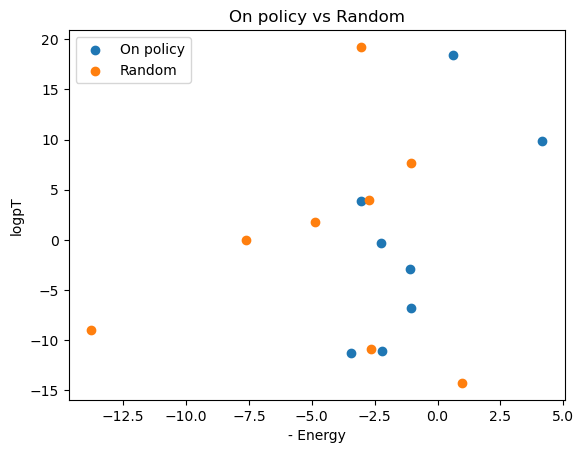

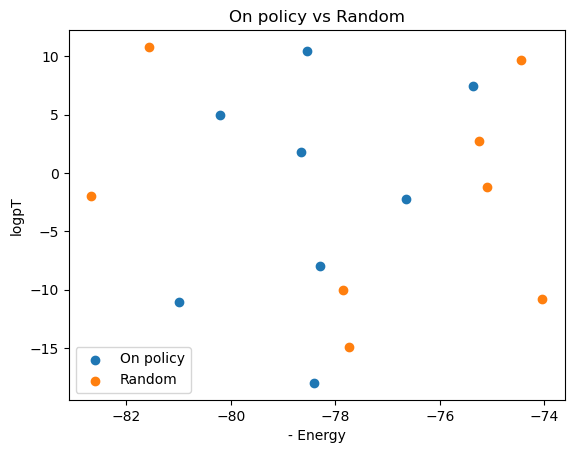

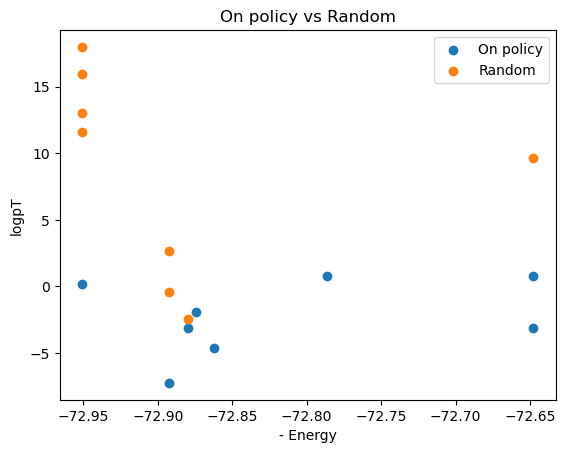

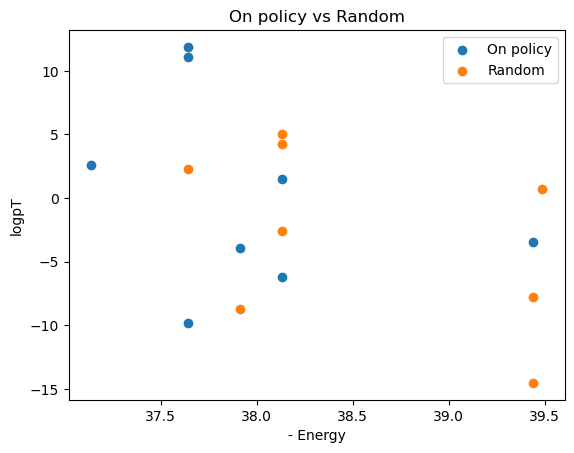

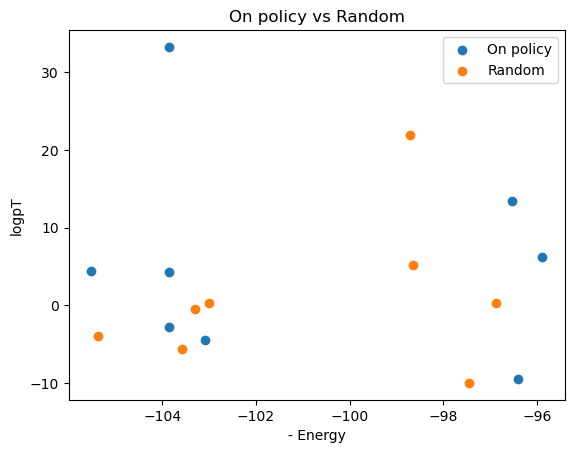

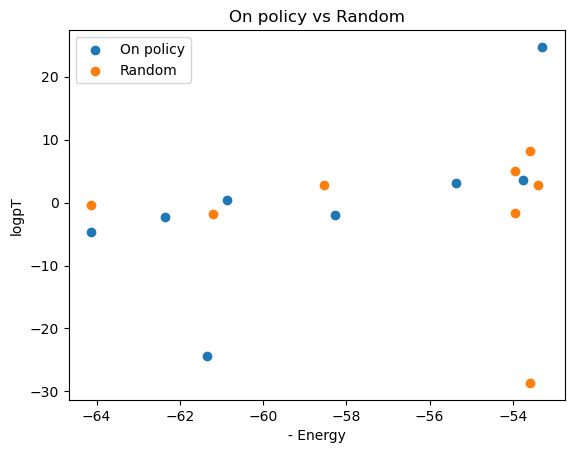

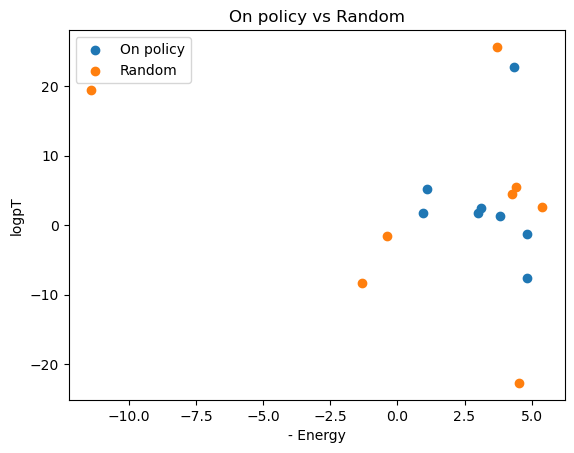

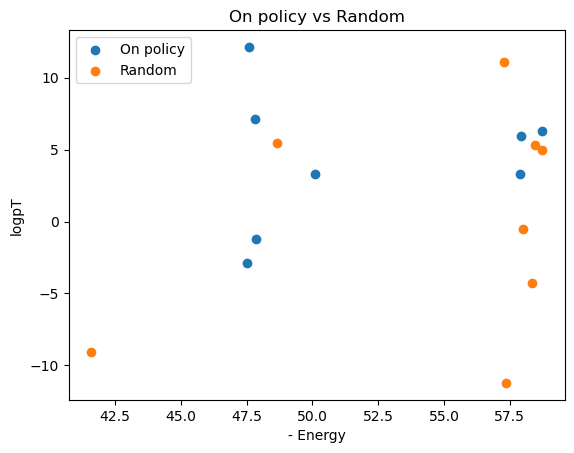

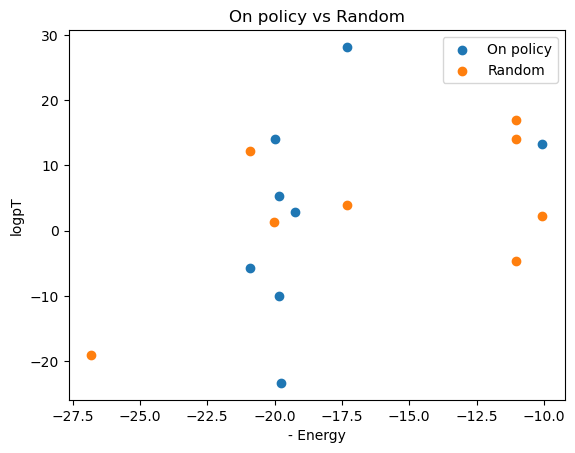

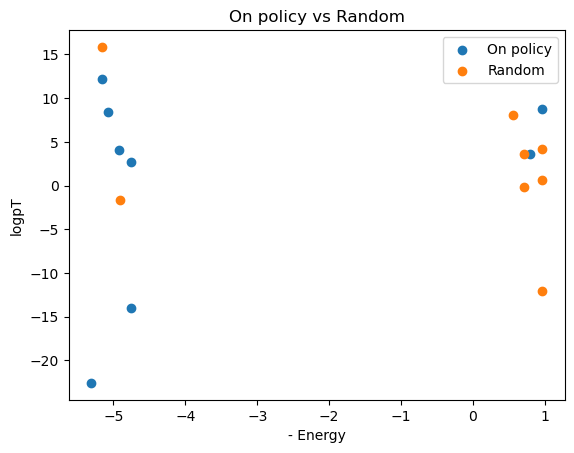

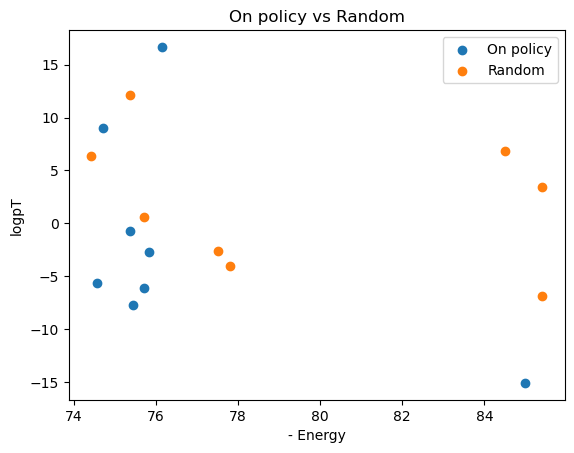

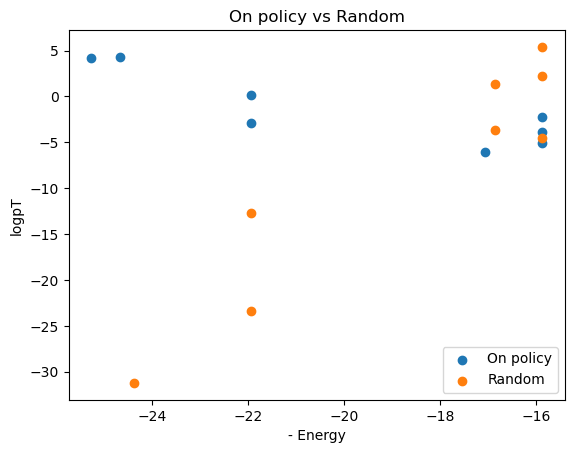

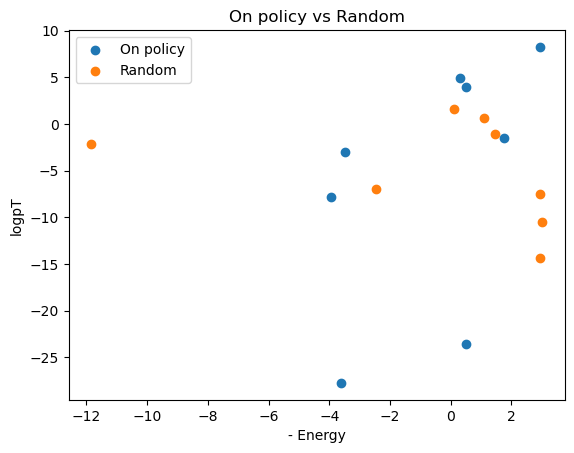

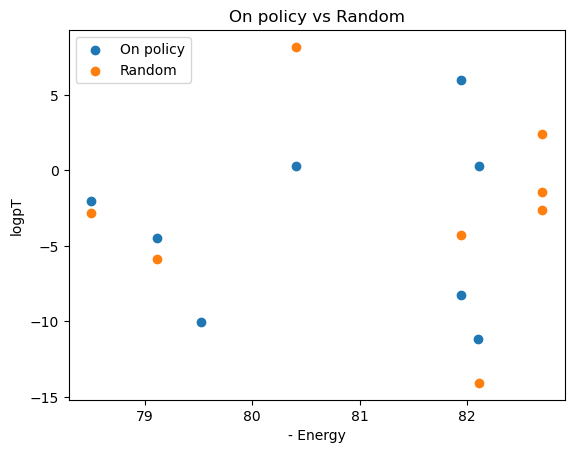

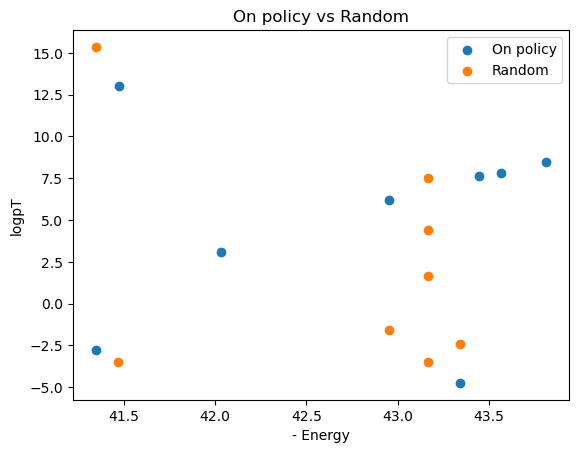

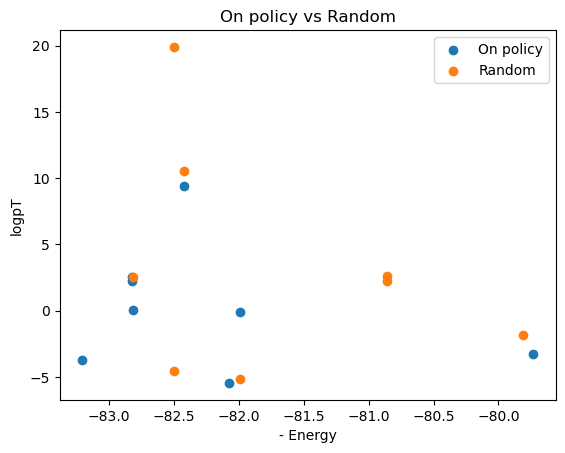

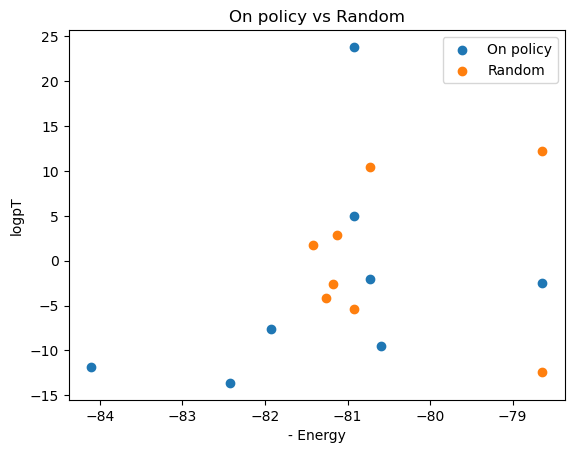

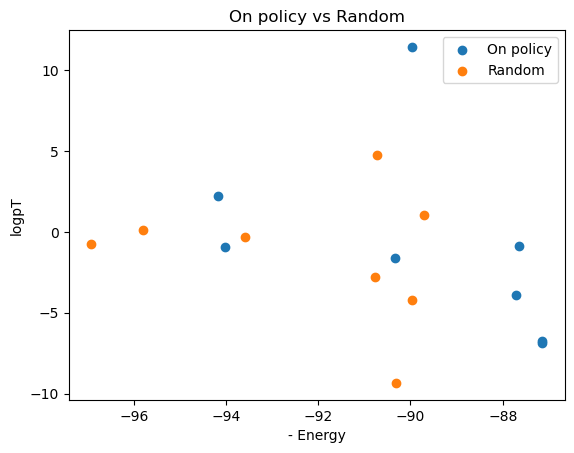

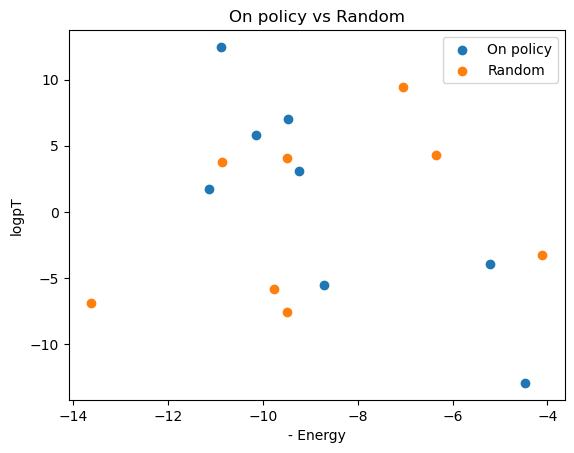

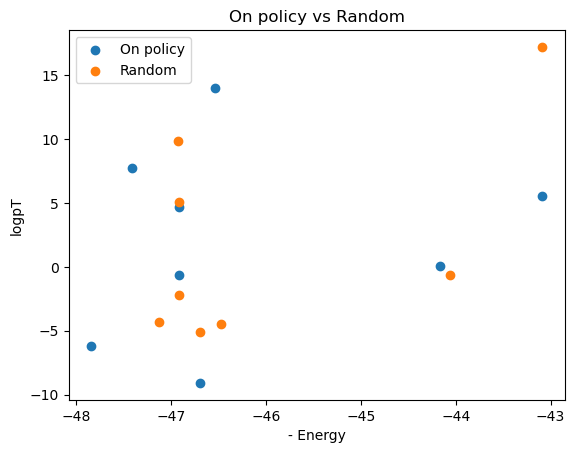

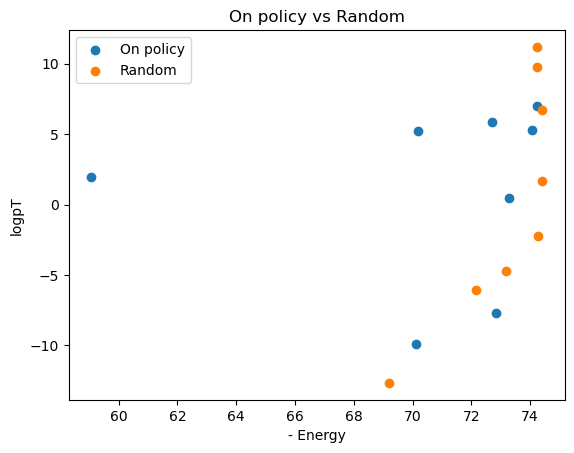

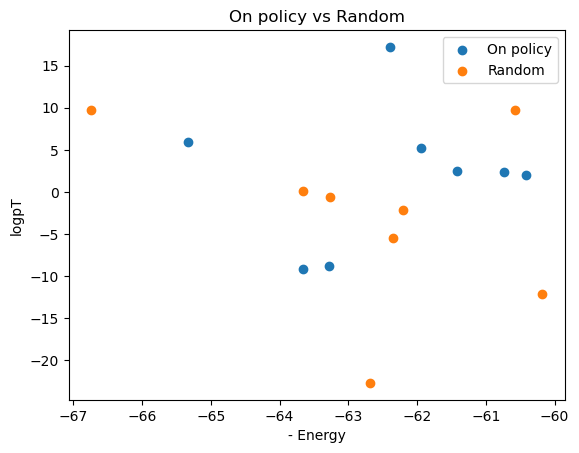

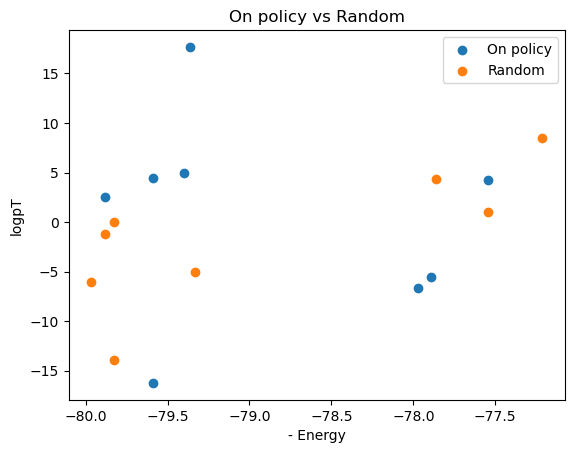

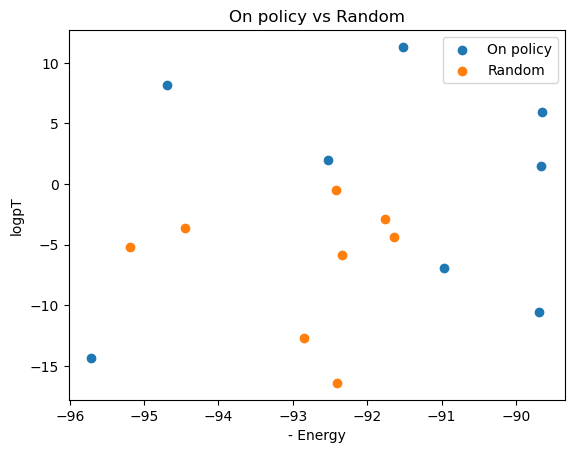

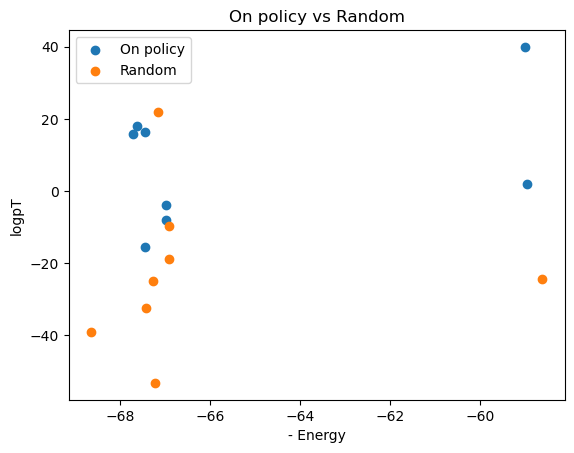

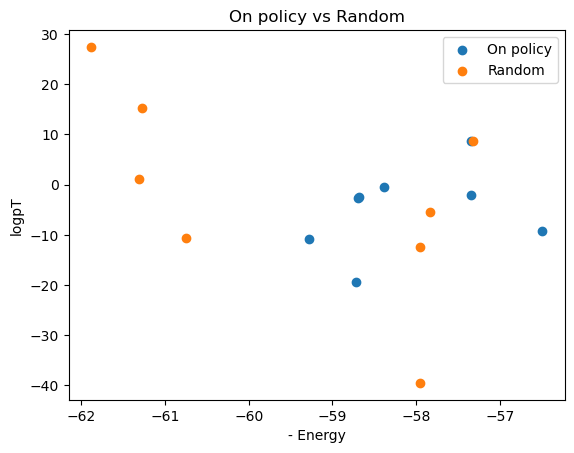

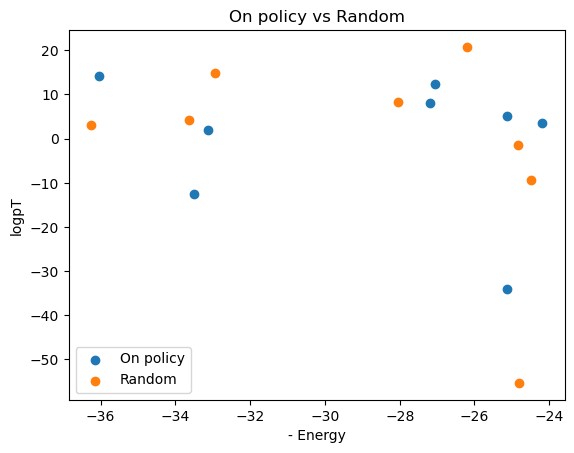

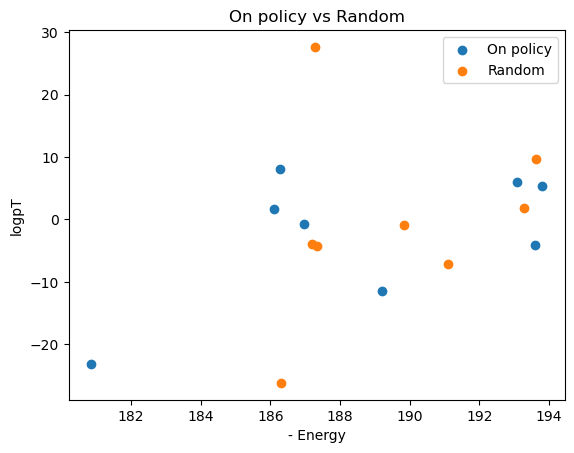

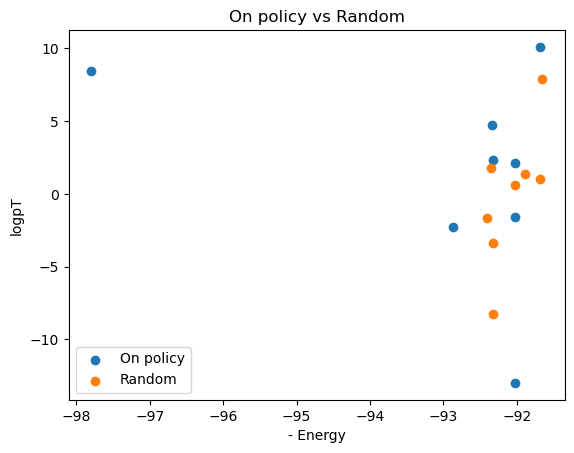

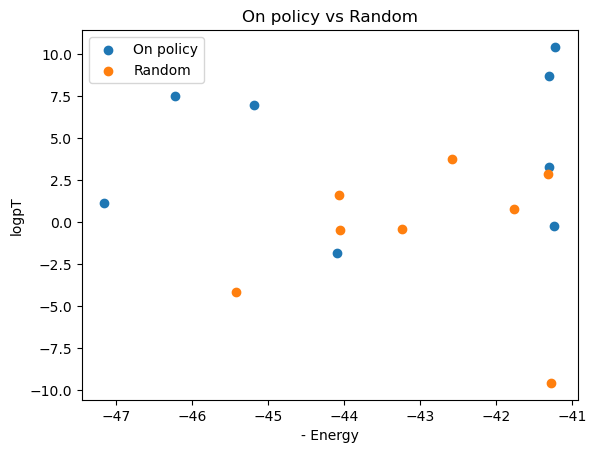

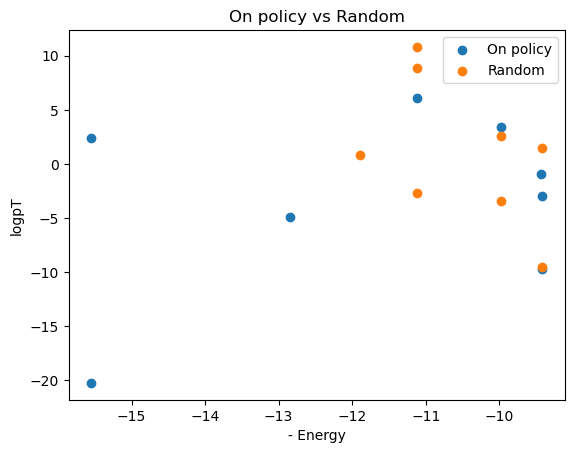

In [10]:
for ix in range(len(energies_train_on_policy)):
    smile = list(energies_train_on_policy.keys())[ix]
    plt.figure()
    plt.scatter(- np.array(energies_train_on_policy[smile]), logpT_train_on_policy[ix], label='On policy')
    plt.scatter( - np.array(energies_train_rand[smile]), logpT_train_rand[ix], label='Random')
    # Set title and labels
    plt.title('On policy vs Random')
    plt.xlabel('- Energy')
    plt.ylabel('logpT')
    plt.legend()
    plt.show()